In [1]:
import pandas as pd 
import numpy as np
import math
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import  LSTM
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dropout
import xgboost
import pickle

**Stock price prediction in 15 minutes for Microsoft, combining models and indicators.**

# DATA COLLECTION

In [2]:
from alpha_vantage.timeseries import TimeSeries
ts = TimeSeries(key='D8JHWTNSXO7M9VKV', output_format='pandas')

In [3]:
data = ts.get_intraday(symbol='MSFT',interval='15min', outputsize='full')
data = data[0]
data.rename(lambda x: x[2:].strip(), axis='columns', inplace=True)
data

open    high     low   close   volume
date                                                        
2023-06-26 19:45:00  329.70  330.00  329.50  329.74   3637.0
2023-06-26 19:30:00  329.76  330.00  329.50  329.70   4756.0
2023-06-26 19:15:00  329.53  330.00  328.60  329.84  23647.0
2023-06-26 19:00:00  329.08  329.74  328.87  329.52   6428.0
2023-06-26 18:45:00  329.00  329.29  328.81  328.82    954.0
...                     ...     ...     ...     ...      ...
2023-05-30 05:00:00  336.30  336.70  336.00  336.35   8878.0
2023-05-30 04:45:00  337.17  337.17  336.00  336.41   9615.0
2023-05-30 04:30:00  336.32  337.43  336.25  337.17  12467.0
2023-05-30 04:15:00  335.72  337.00  335.70  336.52  23289.0
2023-05-30 04:00:00  335.65  335.99  334.20  335.70  22617.0

[1216 rows x 5 columns]

# INDICATORS CALCULATION

In [4]:
from alpha_vantage.techindicators import TechIndicators
ti = TechIndicators(key='D8JHWTNSXO7M9VKV', output_format='pandas')

## 1. Rate of Change (ROC)

In [5]:
indicator_roc = ti.get_roc(symbol='MSFT', interval='15min', time_period=20)
indicator_roc = indicator_roc[0]
indicator_roc

ROC
date                       
2023-05-30 09:00:00  0.3038
2023-05-30 09:15:00 -0.3893
2023-05-30 09:30:00 -0.4864
2023-05-30 09:45:00 -1.3555
2023-05-30 10:00:00 -1.5460
...                     ...
2023-06-26 18:45:00 -0.3485
2023-06-26 19:00:00 -0.1681
2023-06-26 19:15:00 -0.0364
2023-06-26 19:30:00 -0.3867
2023-06-26 19:45:00 -0.1907

[1196 rows x 1 columns]

## 2. Simple Moving Average (SMA)

In [6]:
indicator_sma = ti.get_sma(symbol='MSFT', interval='15min', time_period=20)
indicator_sma = indicator_sma[0]
indicator_sma

SMA
date                         
2023-05-30 08:45:00  336.6495
2023-05-30 09:00:00  336.7005
2023-05-30 09:15:00  336.6350
2023-05-30 09:30:00  336.5530
2023-05-30 09:45:00  336.3250
...                       ...
2023-06-26 18:45:00  329.3116
2023-06-26 19:00:00  329.2839
2023-06-26 19:15:00  329.2779
2023-06-26 19:30:00  329.2139
2023-06-26 19:45:00  329.1824

[1197 rows x 1 columns]

## 3. Relative Strength Index (RSI)

In [7]:
indicator_rsi = ti.get_rsi(symbol='MSFT', interval='15min', time_period=20)
indicator_rsi = indicator_rsi[0]
indicator_rsi

RSI
date                        
2023-05-30 09:00:00  58.4437
2023-05-30 09:15:00  46.2679
2023-05-30 09:30:00  48.6542
2023-05-30 09:45:00  31.6431
2023-05-30 10:00:00  29.5728
...                      ...
2023-06-26 18:45:00  36.9783
2023-06-26 19:00:00  43.1705
2023-06-26 19:15:00  45.7362
2023-06-26 19:30:00  44.8046
2023-06-26 19:45:00  45.1407

[1196 rows x 1 columns]

## 4. Bolling Bands (BBANDS)

In [8]:
def BollingerBand(data, n_loockback, n_std=2):
    hlc_avg = (data.high + data.low + data.close)/3
    data_std = hlc_avg.rolling(window=n_loockback).std()
    data_upper = data.SMA + n_std * data_std
    data_lower = data.SMA - n_std * data_std
    return data.SMA, data_lower, data_upper

In [9]:
# indicator_bb = ti.get_bbands(symbol='MSFT', interval='15min', time_period=20)
# indicator_bb = indicator_bb[0]
# indicator_bb

**Merge indicators to data**

In [10]:
original_df = pd.merge(data, indicator_roc, on='date', how='inner')
original_df = pd.merge(original_df, indicator_sma, on='date', how='inner')
original_df = pd.merge(original_df, indicator_rsi, on='date', how='inner')
# original_df = pd.merge(original_df, indicator_bb, on='date', how='inner')
original_df["Real Middle Band"], original_df["Real Lower Band"], original_df["Real Upper Band"] = BollingerBand(original_df, 20, 2)
original_df = original_df.dropna()
original_df = original_df.iloc[::-1]
original_df.to_csv('./DATA/MSFT.csv')
original_df

open     high     low    close     volume     ROC  \
date                                                                       
2023-05-30 09:00:00  336.65  336.800  336.45  336.720    36329.0  0.3038   
2023-05-30 09:15:00  336.63  337.000  334.80  335.210    99194.0 -0.3893   
2023-05-30 09:30:00  335.23  335.740  332.88  335.530  4039489.0 -0.4864   
2023-05-30 09:45:00  335.56  335.580  330.58  331.850  2107766.0 -1.3555   
2023-05-30 10:00:00  331.80  332.131  330.59  331.150  1311465.0 -1.5460   
...                     ...      ...     ...      ...        ...     ...   
2023-06-26 14:00:00  329.96  330.365  329.70  330.075   445942.0 -1.4731   
2023-06-26 14:15:00  330.06  330.080  329.52  329.960   366852.0 -1.2125   
2023-06-26 14:30:00  329.94  331.000  329.87  330.980   467913.0 -1.0996   
2023-06-26 14:45:00  330.97  331.000  330.29  330.370   363906.0 -1.5026   
2023-06-26 15:00:00  330.38  330.430  329.78  329.915   478434.0 -1.7145   

                          SMA      RSI  Real Middle Band  Real Lower Band  \
date                                                                        
2023-05-30 09:00:00  336.7005  58.4437          336.7005       333.767873   
2023-05-30 09:15:00  336.6350  46.2679          336.6350       334.292771   
2023-05-30 09:30:00  336.5530  48.6542          336.5530       334.773484   
2023-05-30 09:45:00  336.3250  31.6431          336.3250       334.961857   
2023-05-30 10:00:00  336.0650  29.5728          336.0650       334.710192   
...                       ...      ...               ...              ...   
2023-06-26 14:00:00  332.0485  35.6387          332.0485       330.466112   
2023-06-26 14:15:00  331.8460  35.1969          331.8460       330.279465   
2023-06-26 14:30:00  331.6620  41.9190          331.6620       330.103414   
2023-06-26 14:45:00  331.4100  39.3495          331.4100       329.937022   
2023-06-26 15:00:00  331.1223  37.5426          331.1223       329.734206   

                     Real Upper Band  
date                                  
2023-05-30 09:00:00       339.633127  
2023-05-30 09:15:00       338.977229  
2023-05-30 09:30:00       338.332516  
2023-05-30 09:45:00       337.688143  
2023-05-30 10:00:00       337.419808  
...                              ...  
2023-06-26 14:00:00       333.630888  
2023-06-26 14:15:00       333.412535  
2023-06-26 14:30:00       333.220586  
2023-06-26 14:45:00       332.882978  
2023-06-26 15:00:00       332.510394  

[1177 rows x 11 columns]

# MODEL TRAINING

## 1. LSTM

### a. Prepare Input

In [11]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close']].values
dataset

array([[336.72 ],
       [335.21 ],
       [335.53 ],
       ...,
       [330.98 ],
       [330.37 ],
       [329.915]])

In [12]:
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)
dataset

array([[0.50536553],
       [0.45472837],
       [0.46545942],
       ...,
       [0.31287726],
       [0.29242119],
       [0.27716298]])

In [13]:
X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])
print(len(X))
print(len(y))

1117
1117


In [14]:
X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])
print("Size train: ", X_train.shape)
print("Size validate: ", X_val.shape)
print("Size test: ", X_test.shape)

Size train:  (894, 60, 1)
Size validate:  (112, 60, 1)
Size test:  (111, 60, 1)


### b. Train Model

In [15]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM.h5")

Epoch 1/20
28/28 [==============================] - 2s 32ms/step - loss: 0.0389 - val_loss: 0.0017
Epoch 2/20
28/28 [==============================] - 1s 20ms/step - loss: 0.0041 - val_loss: 0.0014
Epoch 3/20
28/28 [==============================] - 1s 20ms/step - loss: 0.0023 - val_loss: 0.0019
Epoch 4/20
28/28 [==============================] - 1s 20ms/step - loss: 0.0021 - val_loss: 0.0011
Epoch 5/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0020 - val_loss: 0.0011
Epoch 6/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0019 - val_loss: 0.0010
Epoch 7/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0018 - val_loss: 0.0012
Epoch 8/20
28/28 [==============================] - 1s 20ms/step - loss: 0.0017 - val_loss: 0.0013
Epoch 9/20
28/28 [==============================] - 1s 20ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 10/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0016 - val_loss: 0.0010
Epoch 11/

### c. Test Model

In [16]:
model_lstm = load_model('./MODEL/LSTM.h5')

In [17]:
predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(predictions)

In [18]:
prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions
prediction_df

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


date    open     high     low    close    volume     ROC  \
1066  2023-06-22 19:30:00  340.31  340.400  340.18  340.270    4121.0  0.4991   
1067  2023-06-22 19:45:00  340.28  340.400  339.62  339.620    6694.0  0.2024   
1068  2023-06-23 04:00:00  338.02  338.980  337.79  338.000    3293.0 -0.2597   
1069  2023-06-23 04:15:00  338.00  338.040  337.38  337.440    1654.0 -0.3485   
1070  2023-06-23 04:30:00  337.50  337.970  337.50  337.770    1242.0 -0.4412   
...                   ...     ...      ...     ...      ...       ...     ...   
1172  2023-06-26 14:00:00  329.96  330.365  329.70  330.075  445942.0 -1.4731   
1173  2023-06-26 14:15:00  330.06  330.080  329.52  329.960  366852.0 -1.2125   
1174  2023-06-26 14:30:00  329.94  331.000  329.87  330.980  467913.0 -1.0996   
1175  2023-06-26 14:45:00  330.97  331.000  330.29  330.370  363906.0 -1.5026   
1176  2023-06-26 15:00:00  330.38  330.430  329.78  329.915  478434.0 -1.7145   

           SMA      RSI  Real Middle Band  Real Lower Band  Real Upper Band  \
1066  339.8570  65.8028          339.8570       338.036420       341.677580   
1067  339.8913  58.1992          339.8913       338.335483       341.447117   
1068  339.8473  44.6605          339.8473       338.361414       341.333186   
1069  339.7883  41.1752          339.7883       338.074026       341.502574   
1070  339.7135  43.8913          339.7135       337.913969       341.513031   
...        ...      ...               ...              ...              ...   
1172  332.0485  35.6387          332.0485       330.466112       333.630888   
1173  331.8460  35.1969          331.8460       330.279465       333.412535   
1174  331.6620  41.9190          331.6620       330.103414       333.220586   
1175  331.4100  39.3495          331.4100       329.937022       332.882978   
1176  331.1223  37.5426          331.1223       329.734206       332.510394   

      predictions  
1066   340.721313  
1067   340.736298  
1068   340.642334  
1069   340.271271  
1070   339.722534  
...           ...  
1172   330.108490  
1173   330.098022  
1174   330.110138  
1175   330.258942  
1176   330.397156  

[111 rows x 13 columns]

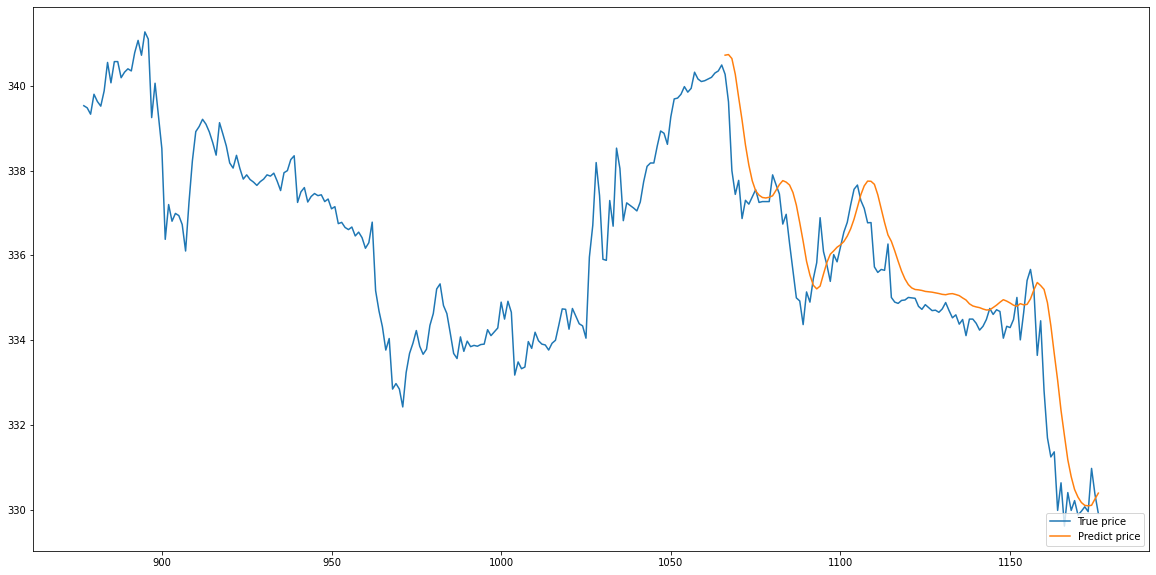

In [19]:
plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

### d. Combine Indicators

#### + ROC

In [20]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'ROC']].values
dataset

array([[ 3.36720e+02,  3.03800e-01],
       [ 3.35210e+02, -3.89300e-01],
       [ 3.35530e+02, -4.86400e-01],
       ...,
       [ 3.30980e+02, -1.09960e+00],
       [ 3.30370e+02, -1.50260e+00],
       [ 3.29915e+02, -1.71450e+00]])

In [21]:
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)
dataset

array([[0.50536553, 0.52491186],
       [0.45472837, 0.41433608],
       [0.46545942, 0.39884495],
       ...,
       [0.31287726, 0.30101626],
       [0.29242119, 0.23672245],
       [0.27716298, 0.20291635]])

In [22]:
X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])
print(len(X))
print(len(y))

1117
1117


In [23]:
X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])
print("Size train: ", X_train.shape)
print("Size validate: ", X_val.shape)
print("Size test: ", X_test.shape)

Size train:  (894, 60, 2)
Size validate:  (112, 60, 2)
Size test:  (111, 60, 2)


In [24]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], 2)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_ROC.h5")

Epoch 1/20
28/28 [==============================] - 2s 30ms/step - loss: 0.0299 - val_loss: 0.0034
Epoch 2/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0039 - val_loss: 0.0027
Epoch 3/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0025 - val_loss: 0.0013
Epoch 4/20
28/28 [==============================] - 1s 20ms/step - loss: 0.0021 - val_loss: 0.0011
Epoch 5/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0019 - val_loss: 9.8323e-04
Epoch 6/20
28/28 [==============================] - 1s 18ms/step - loss: 0.0018 - val_loss: 9.8325e-04
Epoch 7/20
28/28 [==============================] - 1s 18ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 8/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0017 - val_loss: 8.9181e-04
Epoch 9/20
28/28 [==============================] - 1s 20ms/step - loss: 0.0016 - val_loss: 8.8476e-04
Epoch 10/20
28/28 [==============================] - 1s 20ms/step - loss: 0.0015 - val_loss: 

In [25]:
model_lstm = load_model('./MODEL/LSTM_ROC.h5')

In [26]:
predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]
predictions

array([340.25464, 340.23486, 340.0763 , 339.62256, 339.05267, 338.53387,
       337.9445 , 337.50732, 337.18298, 336.98618, 336.91998, 336.8722 ,
       336.83185, 336.81848, 336.8234 , 336.93817, 337.03973, 337.0871 ,
       336.98257, 336.8658 , 336.63358, 336.30136, 335.90387, 335.60153,
       335.2944 , 335.11517, 335.01416, 335.0097 , 335.10742, 335.39133,
       335.57196, 335.65802, 335.61972, 335.6306 , 335.6227 , 335.62936,
       335.7169 , 335.8757 , 336.15002, 336.47095, 336.82205, 337.09808,
       337.2929 , 337.34674, 337.35074, 337.0848 , 336.7439 , 336.38794,
       336.0569 , 335.83676, 335.55655, 335.30496, 335.11777, 334.95816,
       334.8548 , 334.7834 , 334.72372, 334.6738 , 334.59152, 334.48834,
       334.41394, 334.37823, 334.36502, 334.38345, 334.3997 , 334.48035,
       334.59012, 334.65155, 334.6512 , 334.59372, 334.55557, 334.53613,
       334.45773, 334.4184 , 334.3929 , 334.3558 , 334.29382, 334.24426,
       334.24115, 334.30054, 334.3477 , 334.40726, 

In [27]:
prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions
prediction_df

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


date    open     high     low    close    volume     ROC  \
1066  2023-06-22 19:30:00  340.31  340.400  340.18  340.270    4121.0  0.4991   
1067  2023-06-22 19:45:00  340.28  340.400  339.62  339.620    6694.0  0.2024   
1068  2023-06-23 04:00:00  338.02  338.980  337.79  338.000    3293.0 -0.2597   
1069  2023-06-23 04:15:00  338.00  338.040  337.38  337.440    1654.0 -0.3485   
1070  2023-06-23 04:30:00  337.50  337.970  337.50  337.770    1242.0 -0.4412   
...                   ...     ...      ...     ...      ...       ...     ...   
1172  2023-06-26 14:00:00  329.96  330.365  329.70  330.075  445942.0 -1.4731   
1173  2023-06-26 14:15:00  330.06  330.080  329.52  329.960  366852.0 -1.2125   
1174  2023-06-26 14:30:00  329.94  331.000  329.87  330.980  467913.0 -1.0996   
1175  2023-06-26 14:45:00  330.97  331.000  330.29  330.370  363906.0 -1.5026   
1176  2023-06-26 15:00:00  330.38  330.430  329.78  329.915  478434.0 -1.7145   

           SMA      RSI  Real Middle Band  Real Lower Band  Real Upper Band  \
1066  339.8570  65.8028          339.8570       338.036420       341.677580   
1067  339.8913  58.1992          339.8913       338.335483       341.447117   
1068  339.8473  44.6605          339.8473       338.361414       341.333186   
1069  339.7883  41.1752          339.7883       338.074026       341.502574   
1070  339.7135  43.8913          339.7135       337.913969       341.513031   
...        ...      ...               ...              ...              ...   
1172  332.0485  35.6387          332.0485       330.466112       333.630888   
1173  331.8460  35.1969          331.8460       330.279465       333.412535   
1174  331.6620  41.9190          331.6620       330.103414       333.220586   
1175  331.4100  39.3495          331.4100       329.937022       332.882978   
1176  331.1223  37.5426          331.1223       329.734206       332.510394   

      predictions  
1066   340.254639  
1067   340.234863  
1068   340.076294  
1069   339.622559  
1070   339.052673  
...           ...  
1172   329.759857  
1173   329.691620  
1174   329.677551  
1175   329.797119  
1176   329.839600  

[111 rows x 13 columns]

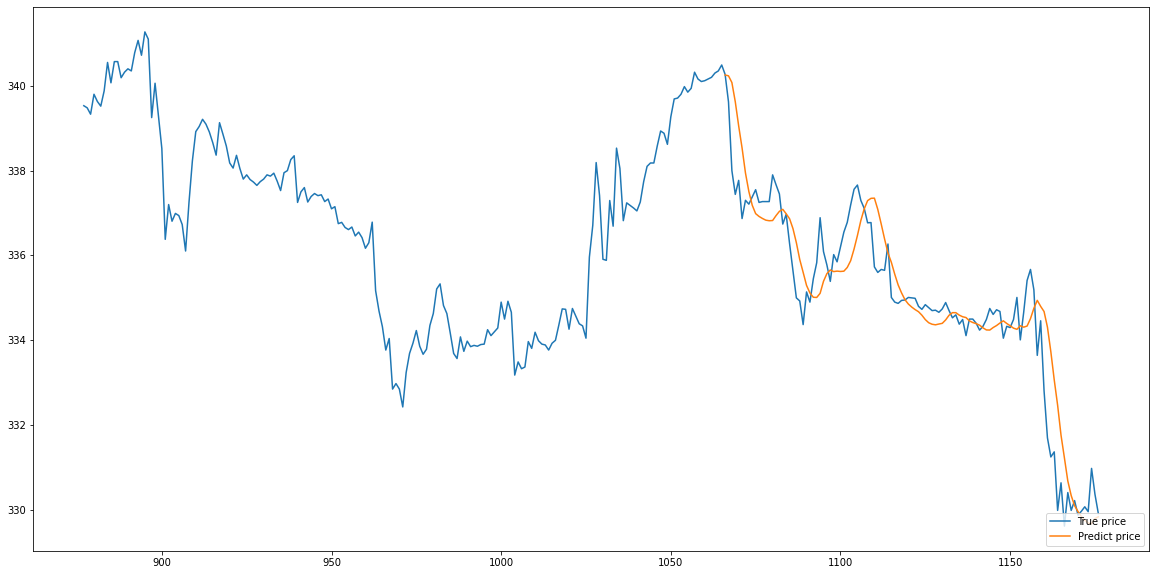

In [28]:
plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + SMA

Epoch 1/20
28/28 [==============================] - 2s 31ms/step - loss: 0.0303 - val_loss: 0.0033
Epoch 2/20
28/28 [==============================] - 1s 18ms/step - loss: 0.0045 - val_loss: 0.0020
Epoch 3/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0031 - val_loss: 0.0018
Epoch 4/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0027 - val_loss: 0.0017
Epoch 5/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0024 - val_loss: 0.0015
Epoch 6/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0021 - val_loss: 0.0011
Epoch 7/20
28/28 [==============================] - 1s 18ms/step - loss: 0.0019 - val_loss: 0.0010
Epoch 8/20
28/28 [==============================] - 1s 18ms/step - loss: 0.0017 - val_loss: 8.8714e-04
Epoch 9/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0017 - val_loss: 9.6351e-04
Epoch 10/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0016 - val_loss: 0.0012
E

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


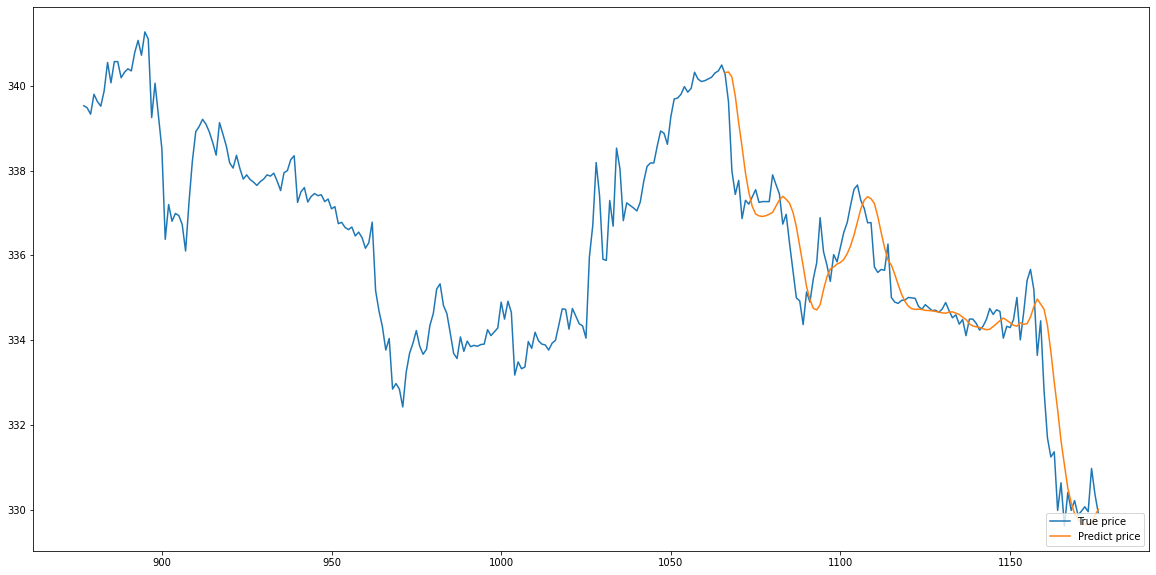

In [29]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], 2)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_SMA.h5")

model_lstm = load_model('./MODEL/LSTM_SMA.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + RSI

Epoch 1/20
28/28 [==============================] - 2s 32ms/step - loss: 0.0276 - val_loss: 0.0018
Epoch 2/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0026 - val_loss: 9.0079e-04
Epoch 3/20
28/28 [==============================] - 1s 18ms/step - loss: 0.0019 - val_loss: 7.8659e-04
Epoch 4/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0017 - val_loss: 7.7078e-04
Epoch 5/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0016 - val_loss: 8.4308e-04
Epoch 6/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0014 - val_loss: 7.2337e-04
Epoch 7/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0014 - val_loss: 6.3402e-04
Epoch 8/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0013 - val_loss: 7.6207e-04
Epoch 9/20
28/28 [==============================] - 1s 18ms/step - loss: 0.0012 - val_loss: 6.1023e-04
Epoch 10/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


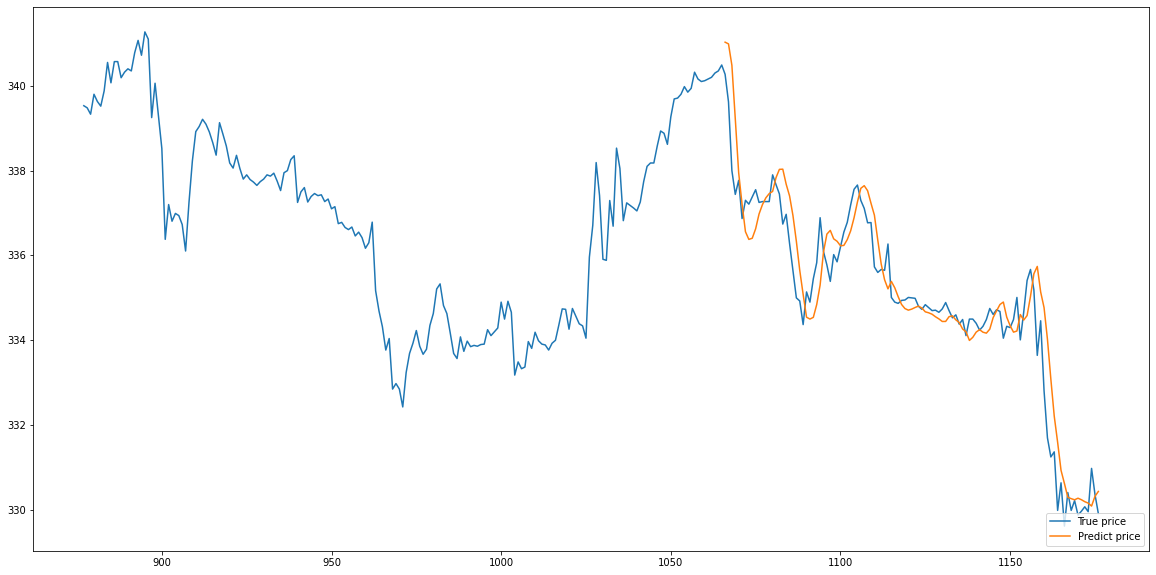

In [30]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'RSI']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], 2)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_RSI.h5")

model_lstm = load_model('./MODEL/LSTM_RSI.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS

Epoch 1/20
28/28 [==============================] - 2s 32ms/step - loss: 0.0122 - val_loss: 0.0026
Epoch 2/20
28/28 [==============================] - 1s 20ms/step - loss: 0.0041 - val_loss: 0.0019
Epoch 3/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0027 - val_loss: 0.0013
Epoch 4/20
28/28 [==============================] - 1s 20ms/step - loss: 0.0024 - val_loss: 0.0011
Epoch 5/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0021 - val_loss: 0.0011
Epoch 6/20
28/28 [==============================] - 1s 20ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 7/20
28/28 [==============================] - 1s 20ms/step - loss: 0.0021 - val_loss: 9.5661e-04
Epoch 8/20
28/28 [==============================] - 1s 20ms/step - loss: 0.0017 - val_loss: 9.3651e-04
Epoch 9/20
28/28 [==============================] - 1s 18ms/step - loss: 0.0017 - val_loss: 0.0011
Epoch 10/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0017 - val_loss: 8.7300e-

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


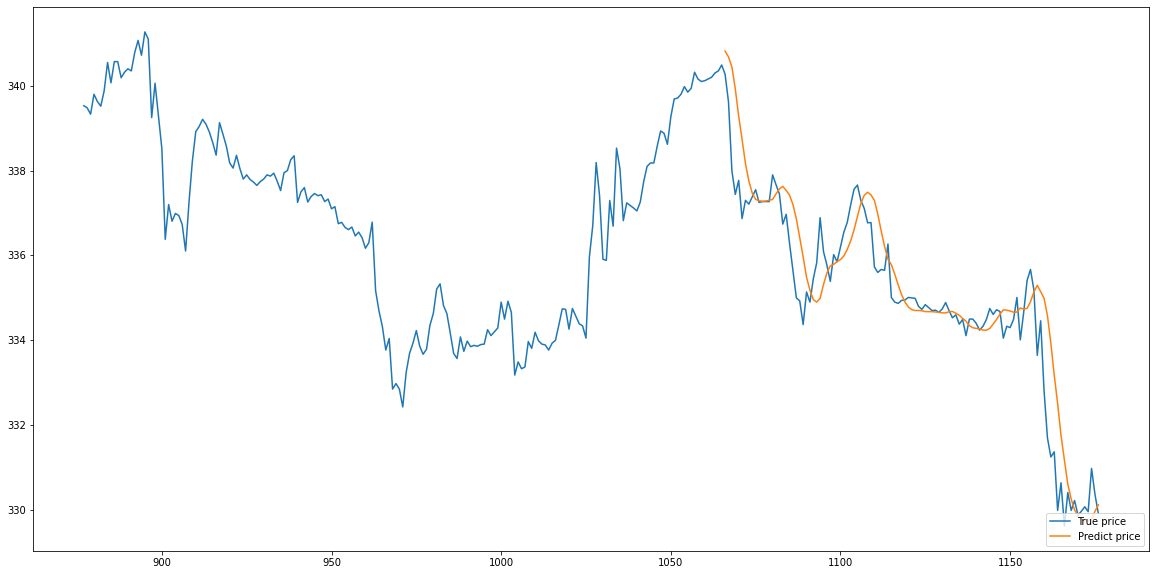

In [31]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_BBANDS.h5")

model_lstm = load_model('./MODEL/LSTM_BBANDS.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + ROC

Epoch 1/20
28/28 [==============================] - 2s 33ms/step - loss: 0.0128 - val_loss: 0.0026
Epoch 2/20
28/28 [==============================] - 1s 20ms/step - loss: 0.0035 - val_loss: 0.0017
Epoch 3/20
28/28 [==============================] - 1s 20ms/step - loss: 0.0023 - val_loss: 0.0014
Epoch 4/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0019 - val_loss: 9.5142e-04
Epoch 5/20
28/28 [==============================] - 1s 18ms/step - loss: 0.0017 - val_loss: 9.8735e-04
Epoch 6/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0017 - val_loss: 0.0011
Epoch 7/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0016 - val_loss: 8.8391e-04
Epoch 8/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0014 - val_loss: 7.2395e-04
Epoch 9/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0013 - val_loss: 6.6886e-04
Epoch 10/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0012 - val_lo

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


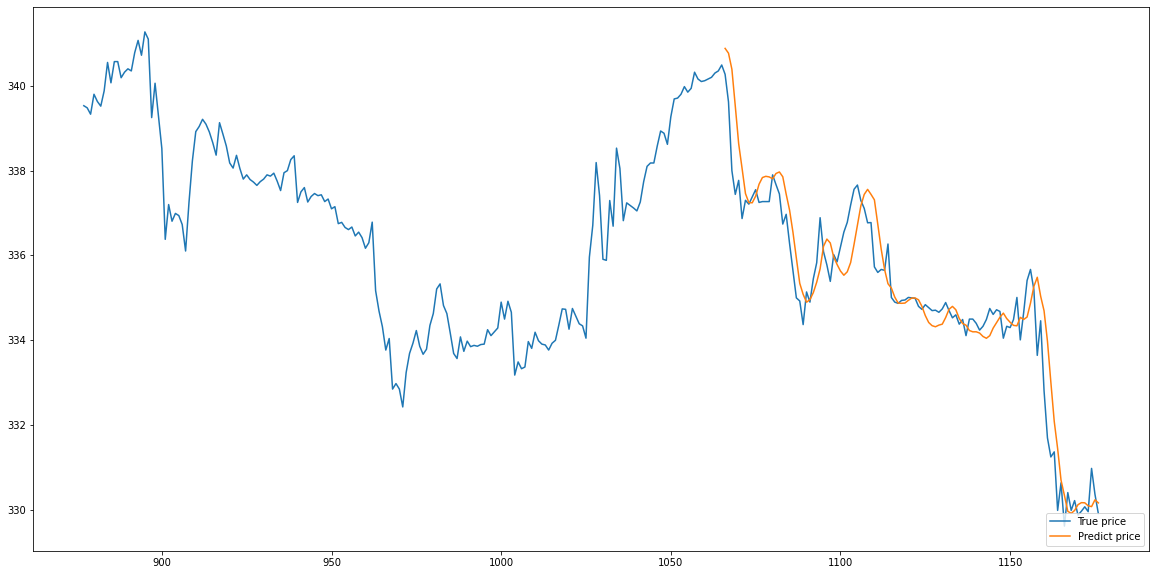

In [32]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_BBANDS_ROC.h5")

model_lstm = load_model('./MODEL/LSTM_BBANDS_ROC.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + RSI

Epoch 1/20
28/28 [==============================] - 2s 32ms/step - loss: 0.0299 - val_loss: 0.0064
Epoch 2/20
28/28 [==============================] - 1s 20ms/step - loss: 0.0050 - val_loss: 0.0022
Epoch 3/20
28/28 [==============================] - 1s 20ms/step - loss: 0.0027 - val_loss: 0.0012
Epoch 4/20
28/28 [==============================] - 1s 20ms/step - loss: 0.0022 - val_loss: 0.0013
Epoch 5/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0021 - val_loss: 0.0012
Epoch 6/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0017 - val_loss: 8.6310e-04
Epoch 7/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0016 - val_loss: 8.1310e-04
Epoch 8/20
28/28 [==============================] - 1s 20ms/step - loss: 0.0014 - val_loss: 8.7508e-04
Epoch 9/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0014 - val_loss: 8.7137e-04
Epoch 10/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0013 - val_loss: 

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


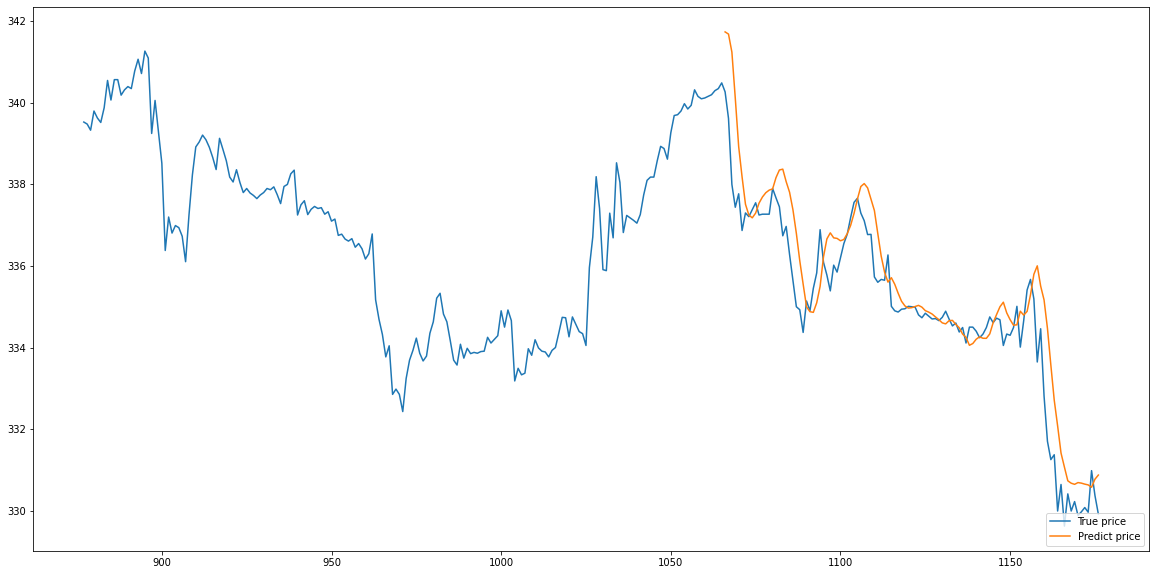

In [33]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'RSI']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_BBANDS_RSI.h5")

model_lstm = load_model('./MODEL/LSTM_BBANDS_RSI.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + SMA

Epoch 1/20
28/28 [==============================] - 2s 33ms/step - loss: 0.0320 - val_loss: 0.0045
Epoch 2/20
28/28 [==============================] - 1s 20ms/step - loss: 0.0055 - val_loss: 0.0027
Epoch 3/20
28/28 [==============================] - 1s 20ms/step - loss: 0.0041 - val_loss: 0.0021
Epoch 4/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0032 - val_loss: 0.0017
Epoch 5/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0027 - val_loss: 0.0012
Epoch 6/20
28/28 [==============================] - 1s 18ms/step - loss: 0.0024 - val_loss: 0.0027
Epoch 7/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0024 - val_loss: 0.0011
Epoch 8/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0020 - val_loss: 0.0012
Epoch 9/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0019 - val_loss: 0.0010
Epoch 10/20
28/28 [==============================] - 1s 20ms/step - loss: 0.0018 - val_loss: 0.0010
Epoch 11/

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


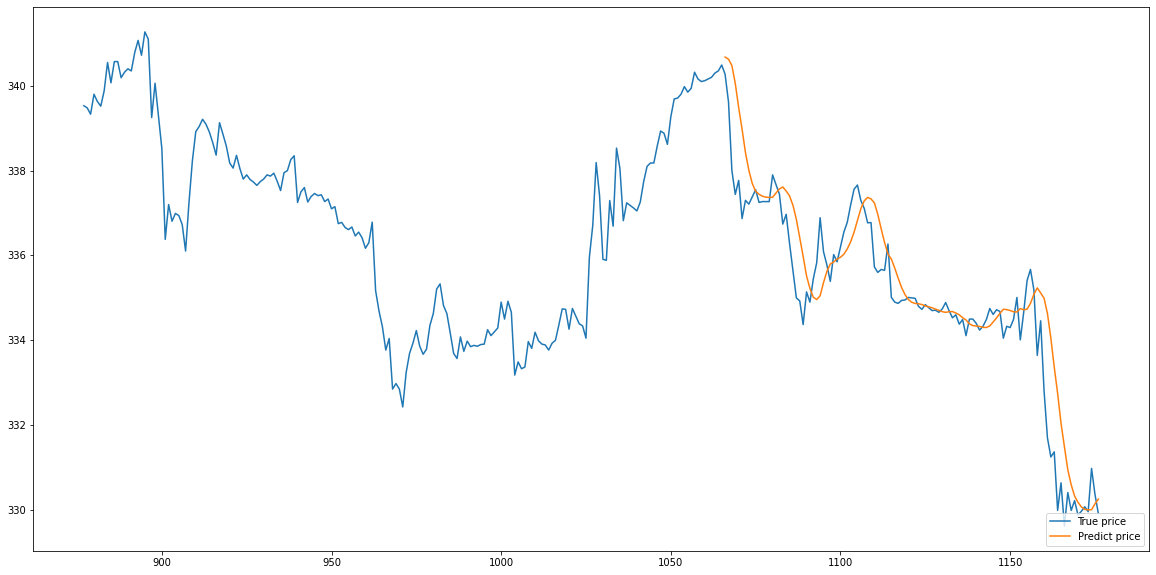

In [34]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_BBANDS_SMA.h5")

model_lstm = load_model('./MODEL/LSTM_BBANDS_SMA.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + ROC + RSI

Epoch 1/20
28/28 [==============================] - 2s 32ms/step - loss: 0.0388 - val_loss: 0.0046
Epoch 2/20
28/28 [==============================] - 1s 20ms/step - loss: 0.0038 - val_loss: 0.0016
Epoch 3/20
28/28 [==============================] - 1s 20ms/step - loss: 0.0022 - val_loss: 0.0015
Epoch 4/20
28/28 [==============================] - 1s 20ms/step - loss: 0.0018 - val_loss: 8.6758e-04
Epoch 5/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0017 - val_loss: 7.7115e-04
Epoch 6/20
28/28 [==============================] - 1s 20ms/step - loss: 0.0016 - val_loss: 7.3938e-04
Epoch 7/20
28/28 [==============================] - 1s 18ms/step - loss: 0.0015 - val_loss: 8.2221e-04
Epoch 8/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0014 - val_loss: 8.3742e-04
Epoch 9/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0014 - val_loss: 9.3796e-04
Epoch 10/20
28/28 [==============================] - 1s 20ms/step - loss: 0.0013 - va

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


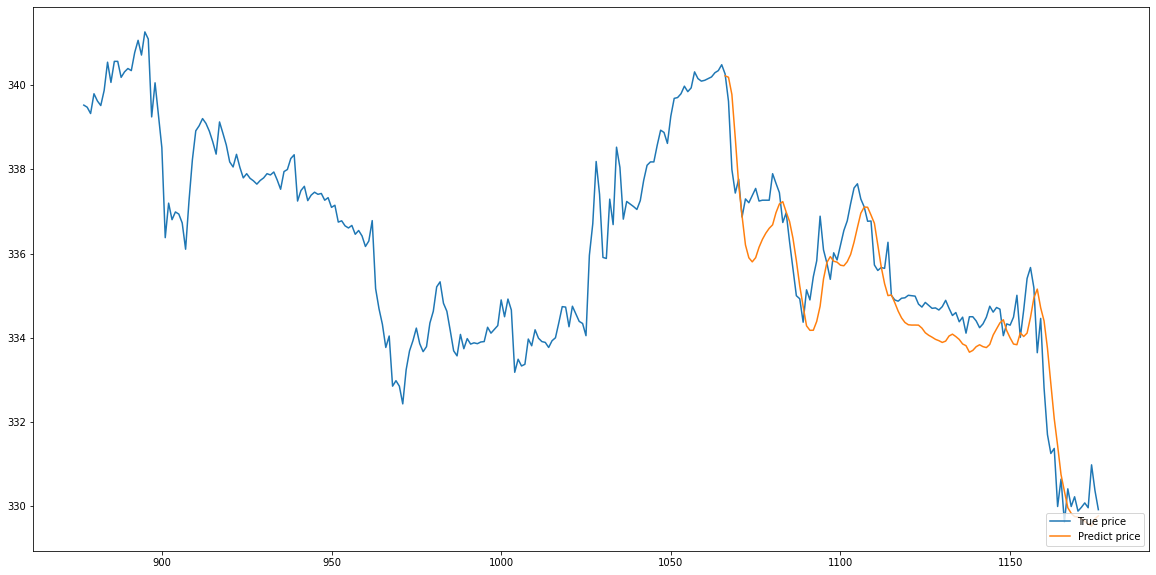

In [35]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'ROC', 'RSI']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_ROC_RSI.h5")

model_lstm = load_model('./MODEL/LSTM_ROC_RSI.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + ROC + SMA

Epoch 1/20
28/28 [==============================] - 2s 34ms/step - loss: 0.0340 - val_loss: 0.0037
Epoch 2/20
28/28 [==============================] - 1s 20ms/step - loss: 0.0039 - val_loss: 0.0018
Epoch 3/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0025 - val_loss: 0.0012
Epoch 4/20
28/28 [==============================] - 1s 21ms/step - loss: 0.0020 - val_loss: 9.8910e-04
Epoch 5/20
28/28 [==============================] - 1s 21ms/step - loss: 0.0019 - val_loss: 9.7563e-04
Epoch 6/20
28/28 [==============================] - 1s 20ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 7/20
28/28 [==============================] - 1s 20ms/step - loss: 0.0017 - val_loss: 9.2545e-04
Epoch 8/20
28/28 [==============================] - 1s 21ms/step - loss: 0.0016 - val_loss: 8.5705e-04
Epoch 9/20
28/28 [==============================] - 1s 22ms/step - loss: 0.0016 - val_loss: 9.4186e-04
Epoch 10/20
28/28 [==============================] - 1s 20ms/step - loss: 0.0018 - val_lo

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


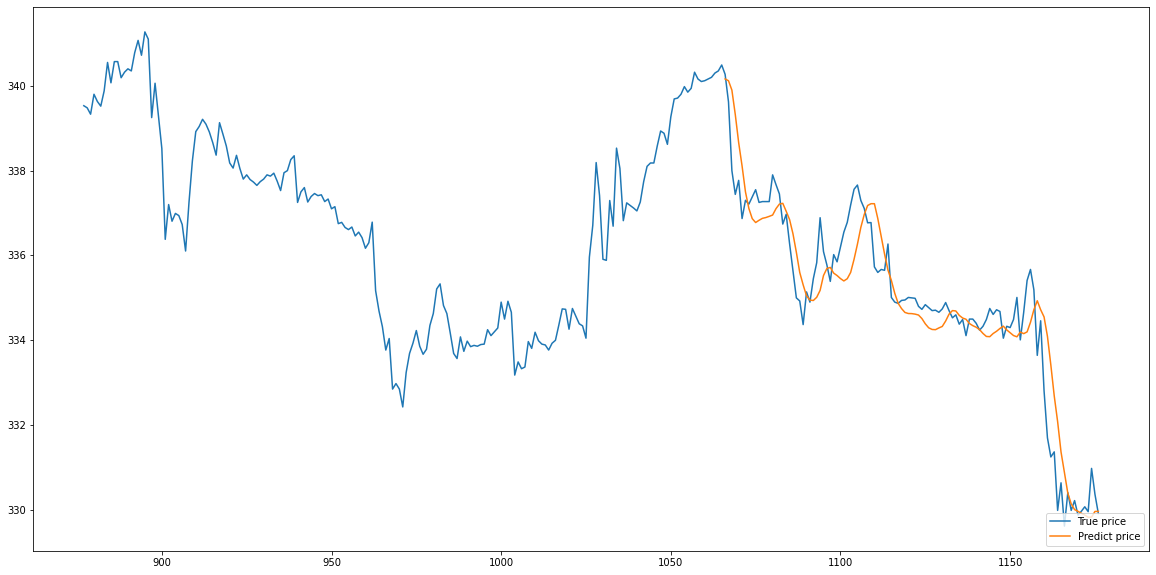

In [36]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'ROC', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_ROC_SMA.h5")

model_lstm = load_model('./MODEL/LSTM_ROC_SMA.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + RSI + SMA

Epoch 1/20
28/28 [==============================] - 2s 33ms/step - loss: 0.0338 - val_loss: 0.0046
Epoch 2/20
28/28 [==============================] - 1s 20ms/step - loss: 0.0042 - val_loss: 0.0014
Epoch 3/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0025 - val_loss: 7.3576e-04
Epoch 4/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0018 - val_loss: 8.6054e-04
Epoch 5/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0017 - val_loss: 8.8560e-04
Epoch 6/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0015 - val_loss: 6.6164e-04
Epoch 7/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0014 - val_loss: 7.7409e-04
Epoch 8/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0014 - val_loss: 7.2717e-04
Epoch 9/20
28/28 [==============================] - 1s 18ms/step - loss: 0.0013 - val_loss: 6.6838e-04
Epoch 10/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0012 

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


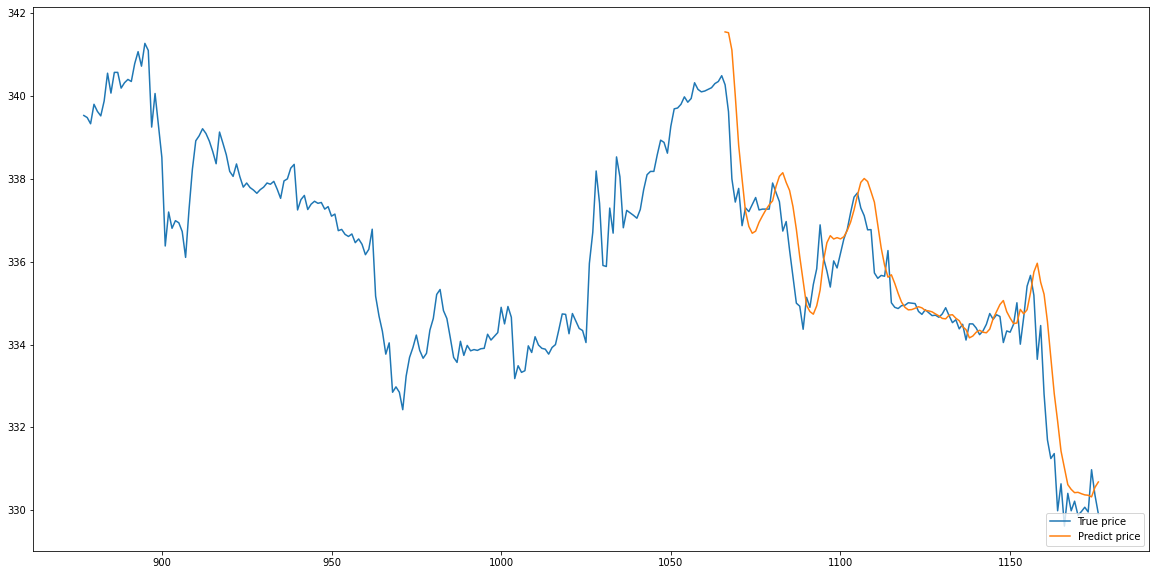

In [37]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'RSI', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_RSI_SMA.h5")

model_lstm = load_model('./MODEL/LSTM_RSI_SMA.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + ROC + RSI

Epoch 1/20
28/28 [==============================] - 2s 34ms/step - loss: 0.0254 - val_loss: 0.0035
Epoch 2/20
28/28 [==============================] - 1s 21ms/step - loss: 0.0033 - val_loss: 8.6961e-04
Epoch 3/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0019 - val_loss: 0.0011
Epoch 4/20
28/28 [==============================] - 1s 20ms/step - loss: 0.0016 - val_loss: 7.4066e-04
Epoch 5/20
28/28 [==============================] - 1s 20ms/step - loss: 0.0015 - val_loss: 6.6927e-04
Epoch 6/20
28/28 [==============================] - 1s 20ms/step - loss: 0.0017 - val_loss: 6.4378e-04
Epoch 7/20
28/28 [==============================] - 1s 20ms/step - loss: 0.0014 - val_loss: 6.1698e-04
Epoch 8/20
28/28 [==============================] - 1s 20ms/step - loss: 0.0014 - val_loss: 6.5844e-04
Epoch 9/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 10/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0012 - va

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


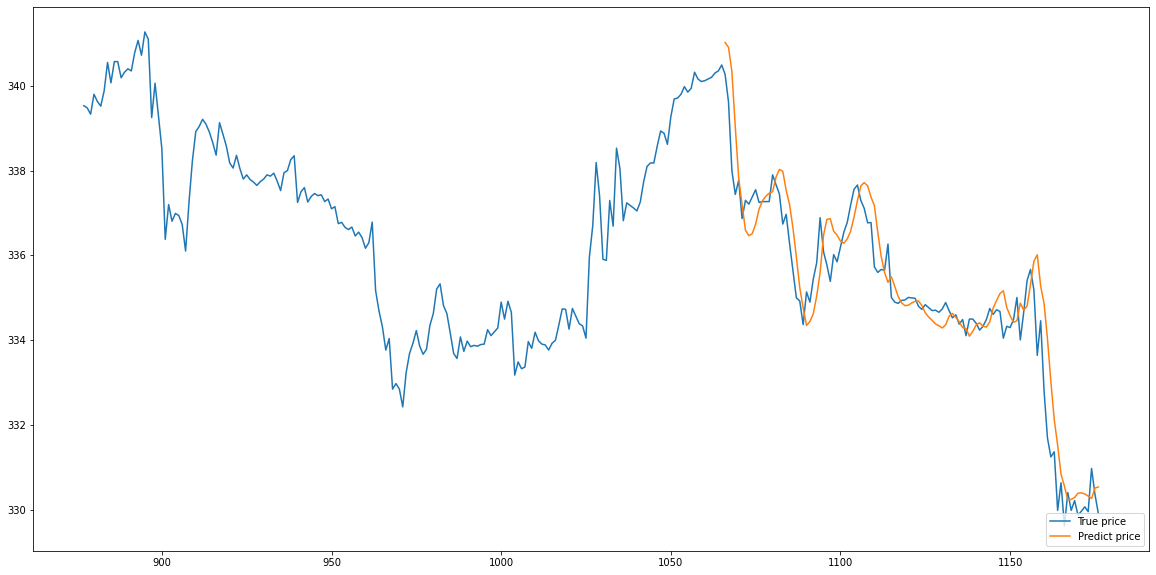

In [38]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'RSI']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_BBANDS_ROC_RSI.h5")

model_lstm = load_model('./MODEL/LSTM_BBANDS_ROC_RSI.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + ROC + SMA

Epoch 1/20
28/28 [==============================] - 2s 33ms/step - loss: 0.0173 - val_loss: 0.0041
Epoch 2/20
28/28 [==============================] - 1s 21ms/step - loss: 0.0037 - val_loss: 0.0028
Epoch 3/20
28/28 [==============================] - 1s 20ms/step - loss: 0.0023 - val_loss: 0.0012
Epoch 4/20
28/28 [==============================] - 1s 20ms/step - loss: 0.0020 - val_loss: 0.0014
Epoch 5/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0021 - val_loss: 0.0012
Epoch 6/20
28/28 [==============================] - 1s 20ms/step - loss: 0.0018 - val_loss: 9.5847e-04
Epoch 7/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0017 - val_loss: 8.7268e-04
Epoch 8/20
28/28 [==============================] - 1s 20ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 9/20
28/28 [==============================] - 1s 18ms/step - loss: 0.0016 - val_loss: 8.2034e-04
Epoch 10/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0015 - val_loss: 8.35

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


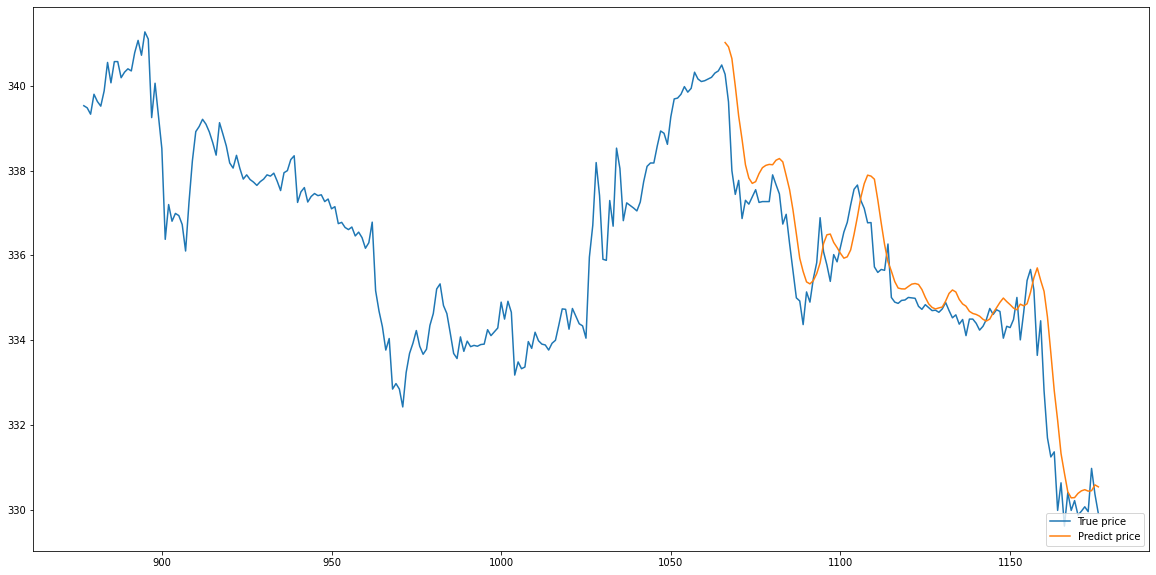

In [39]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_BBANDS_ROC_SMA.h5")

model_lstm = load_model('./MODEL/LSTM_BBANDS_ROC_SMA.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + RSI + SMA

Epoch 1/20
28/28 [==============================] - 2s 33ms/step - loss: 0.0219 - val_loss: 0.0029
Epoch 2/20
28/28 [==============================] - 1s 20ms/step - loss: 0.0037 - val_loss: 0.0012
Epoch 3/20
28/28 [==============================] - 1s 20ms/step - loss: 0.0021 - val_loss: 0.0011
Epoch 4/20
28/28 [==============================] - 1s 20ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 5/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0015 - val_loss: 8.0709e-04
Epoch 6/20
28/28 [==============================] - 1s 21ms/step - loss: 0.0014 - val_loss: 7.1620e-04
Epoch 7/20
28/28 [==============================] - 1s 21ms/step - loss: 0.0013 - val_loss: 7.7409e-04
Epoch 8/20
28/28 [==============================] - 1s 21ms/step - loss: 0.0013 - val_loss: 7.9632e-04
Epoch 9/20
28/28 [==============================] - 1s 20ms/step - loss: 0.0013 - val_loss: 8.2344e-04
Epoch 10/20
28/28 [==============================] - 1s 20ms/step - loss: 0.0012 - val_lo

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


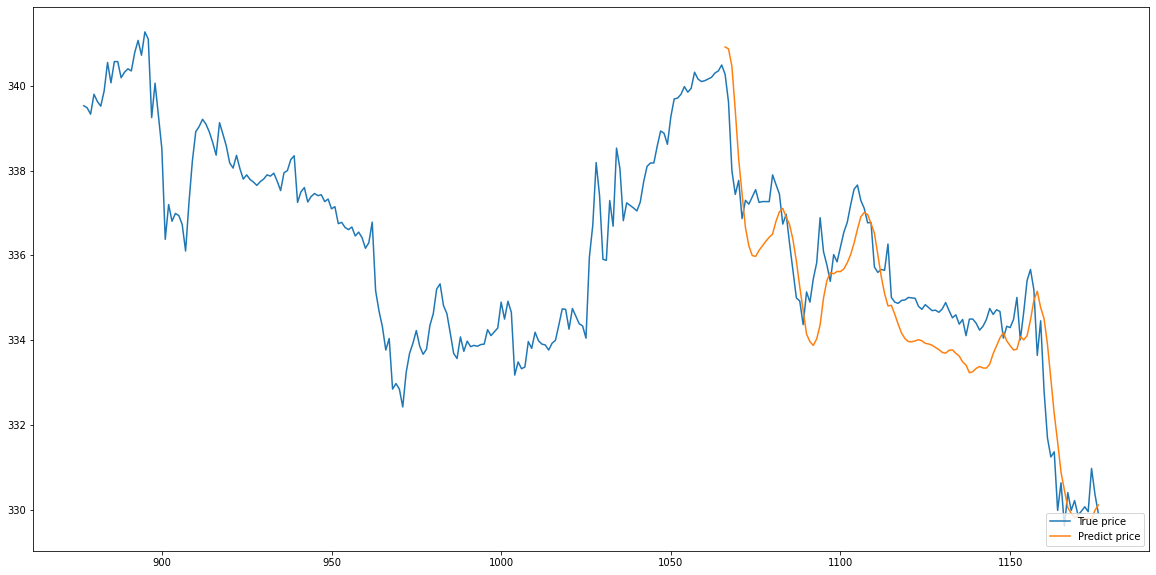

In [40]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'RSI', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_BBANDS_RSI_SMA.h5")

model_lstm = load_model('./MODEL/LSTM_BBANDS_RSI_SMA.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + ROC + RSI + SMA

Epoch 1/20
28/28 [==============================] - 3s 33ms/step - loss: 0.0337 - val_loss: 0.0067
Epoch 2/20
28/28 [==============================] - 1s 20ms/step - loss: 0.0056 - val_loss: 0.0022
Epoch 3/20
28/28 [==============================] - 1s 20ms/step - loss: 0.0031 - val_loss: 9.7802e-04
Epoch 4/20
28/28 [==============================] - 1s 21ms/step - loss: 0.0022 - val_loss: 8.8518e-04
Epoch 5/20
28/28 [==============================] - 1s 20ms/step - loss: 0.0020 - val_loss: 9.2791e-04
Epoch 6/20
28/28 [==============================] - 1s 20ms/step - loss: 0.0017 - val_loss: 7.4571e-04
Epoch 7/20
28/28 [==============================] - 1s 20ms/step - loss: 0.0015 - val_loss: 7.1320e-04
Epoch 8/20
28/28 [==============================] - 1s 20ms/step - loss: 0.0014 - val_loss: 6.6059e-04
Epoch 9/20
28/28 [==============================] - 1s 21ms/step - loss: 0.0013 - val_loss: 6.5819e-04
Epoch 10/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0014 

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


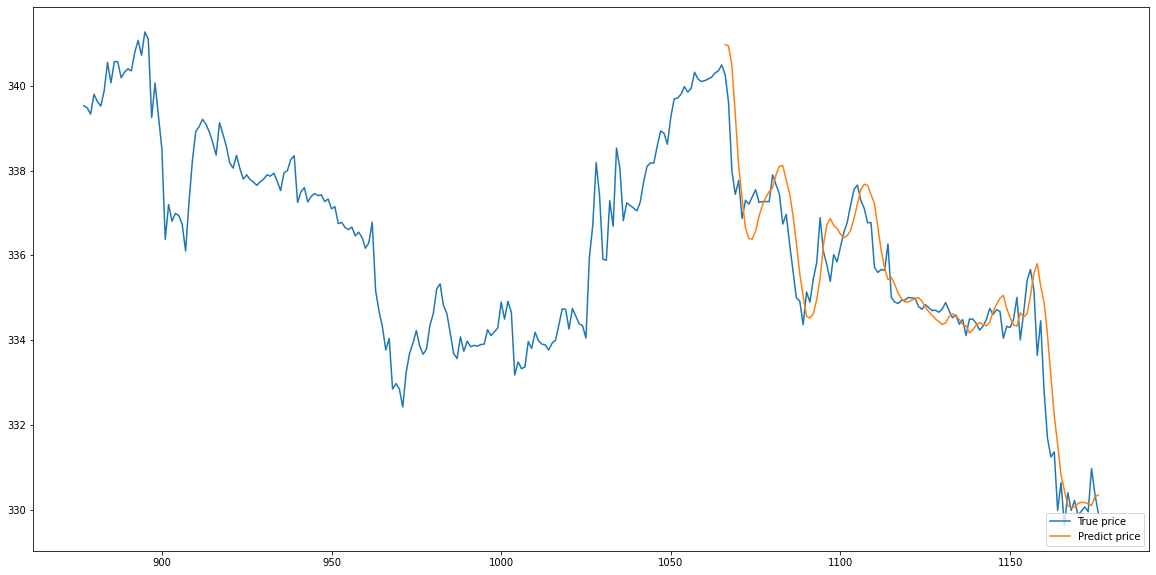

In [41]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'ROC', 'RSI', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_ROC_RSI_SMA.h5")

model_lstm = load_model('./MODEL/LSTM_ROC_RSI_SMA.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + ROC + RSI + SMA

Epoch 1/20
28/28 [==============================] - 2s 32ms/step - loss: 0.0199 - val_loss: 0.0042
Epoch 2/20
28/28 [==============================] - 1s 21ms/step - loss: 0.0036 - val_loss: 0.0013
Epoch 3/20
28/28 [==============================] - 1s 21ms/step - loss: 0.0020 - val_loss: 0.0015
Epoch 4/20
28/28 [==============================] - 1s 21ms/step - loss: 0.0017 - val_loss: 7.8964e-04
Epoch 5/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0015 - val_loss: 7.3714e-04
Epoch 6/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0016 - val_loss: 6.7715e-04
Epoch 7/20
28/28 [==============================] - 1s 20ms/step - loss: 0.0013 - val_loss: 6.8093e-04
Epoch 8/20
28/28 [==============================] - 1s 22ms/step - loss: 0.0013 - val_loss: 6.0709e-04
Epoch 9/20
28/28 [==============================] - 1s 21ms/step - loss: 0.0013 - val_loss: 9.4839e-04
Epoch 10/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0011 - va

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


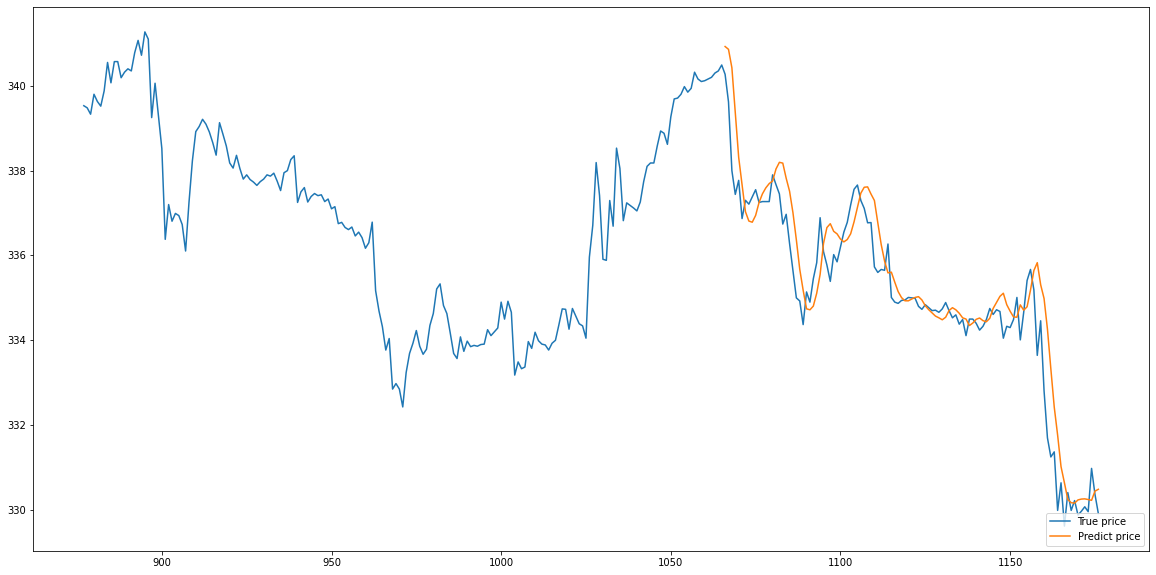

In [42]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'RSI', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_BBANDS_ROC_RSI_SMA.h5")

model_lstm = load_model('./MODEL/LSTM_BBANDS_ROC_RSI_SMA.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

### e. Predict Future

In [43]:
def lstm_predict_future(data, modelName, indicatorArr, period):
    modelFileName = './MODEL/' + modelName
    sorted(indicatorArr)
    for indicator in indicatorArr:
        if indicator == 'close':
            continue
        modelFileName = modelFileName + '_' + indicator
    modelFileName = modelFileName + '.h5'
    model = load_model(modelFileName)
    numDataPoint = int(period / 15)
    
    data = data[indicatorArr].values
    data = data[-60:]

    scaler = MinMaxScaler(feature_range=(0,1))
    scaledData = scaler.fit_transform(data)

    modelInput = scaledData.reshape(-1, scaledData.shape[0], scaledData.shape[1])

    predictedScaledValue = model.predict(modelInput)

    predictedValue = scaler.inverse_transform(np.tile(predictedScaledValue, (1, scaledData.shape[1])))[:, 0]
    
    return predictedValue

## 2. RNN

### a. Prepare Input

In [44]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close']].values
dataset

array([[336.72 ],
       [335.21 ],
       [335.53 ],
       ...,
       [330.98 ],
       [330.37 ],
       [329.915]])

In [45]:
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)
dataset

array([[0.50536553],
       [0.45472837],
       [0.46545942],
       ...,
       [0.31287726],
       [0.29242119],
       [0.27716298]])

In [46]:
X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])
print(len(X))
print(len(y))

1117
1117


In [47]:
X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])
print("Size train: ", X_train.shape)
print("Size validate: ", X_val.shape)
print("Size test: ", X_test.shape)

Size train:  (894, 60, 1)
Size validate:  (112, 60, 1)
Size test:  (111, 60, 1)


### b. Train Model

In [48]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN.h5")

Epoch 1/25
28/28 [==============================] - 5s 68ms/step - loss: 0.0344 - val_loss: 0.0105
Epoch 2/25
28/28 [==============================] - 1s 40ms/step - loss: 0.0096 - val_loss: 0.0043
Epoch 3/25
28/28 [==============================] - 1s 42ms/step - loss: 0.0067 - val_loss: 0.0055
Epoch 4/25
28/28 [==============================] - 1s 40ms/step - loss: 0.0082 - val_loss: 0.0025
Epoch 5/25
28/28 [==============================] - 1s 42ms/step - loss: 0.0063 - val_loss: 0.0028
Epoch 6/25
28/28 [==============================] - 1s 41ms/step - loss: 0.0066 - val_loss: 0.0021
Epoch 7/25
28/28 [==============================] - 1s 41ms/step - loss: 0.0056 - val_loss: 0.0022
Epoch 8/25
28/28 [==============================] - 1s 42ms/step - loss: 0.0052 - val_loss: 0.0018
Epoch 9/25
28/28 [==============================] - 1s 40ms/step - loss: 0.0052 - val_loss: 0.0019
Epoch 10/25
28/28 [==============================] - 1s 42ms/step - loss: 0.0052 - val_loss: 0.0017
Epoch 11/

### c. Test Model

In [49]:
model_rnn = load_model('./MODEL/RNN.h5')

In [50]:
predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(predictions)

In [51]:
prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions
prediction_df

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


date    open     high     low    close    volume     ROC  \
1066  2023-06-22 19:30:00  340.31  340.400  340.18  340.270    4121.0  0.4991   
1067  2023-06-22 19:45:00  340.28  340.400  339.62  339.620    6694.0  0.2024   
1068  2023-06-23 04:00:00  338.02  338.980  337.79  338.000    3293.0 -0.2597   
1069  2023-06-23 04:15:00  338.00  338.040  337.38  337.440    1654.0 -0.3485   
1070  2023-06-23 04:30:00  337.50  337.970  337.50  337.770    1242.0 -0.4412   
...                   ...     ...      ...     ...      ...       ...     ...   
1172  2023-06-26 14:00:00  329.96  330.365  329.70  330.075  445942.0 -1.4731   
1173  2023-06-26 14:15:00  330.06  330.080  329.52  329.960  366852.0 -1.2125   
1174  2023-06-26 14:30:00  329.94  331.000  329.87  330.980  467913.0 -1.0996   
1175  2023-06-26 14:45:00  330.97  331.000  330.29  330.370  363906.0 -1.5026   
1176  2023-06-26 15:00:00  330.38  330.430  329.78  329.915  478434.0 -1.7145   

           SMA      RSI  Real Middle Band  Real Lower Band  Real Upper Band  \
1066  339.8570  65.8028          339.8570       338.036420       341.677580   
1067  339.8913  58.1992          339.8913       338.335483       341.447117   
1068  339.8473  44.6605          339.8473       338.361414       341.333186   
1069  339.7883  41.1752          339.7883       338.074026       341.502574   
1070  339.7135  43.8913          339.7135       337.913969       341.513031   
...        ...      ...               ...              ...              ...   
1172  332.0485  35.6387          332.0485       330.466112       333.630888   
1173  331.8460  35.1969          331.8460       330.279465       333.412535   
1174  331.6620  41.9190          331.6620       330.103414       333.220586   
1175  331.4100  39.3495          331.4100       329.937022       332.882978   
1176  331.1223  37.5426          331.1223       329.734206       332.510394   

      predictions  
1066   340.052002  
1067   340.072052  
1068   340.077332  
1069   340.032471  
1070   339.904724  
...           ...  
1172   329.954803  
1173   329.677612  
1174   329.480530  
1175   329.368042  
1176   329.332794  

[111 rows x 13 columns]

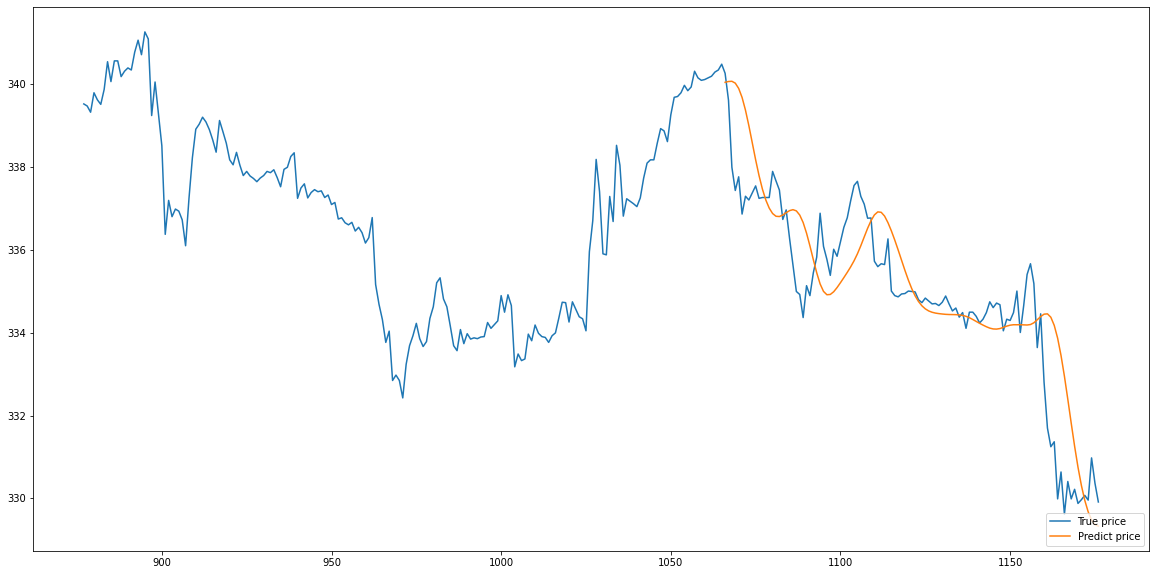

In [52]:
plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

### d. Combine Indicators

#### + ROC

In [53]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'ROC']].values
dataset

array([[ 3.36720e+02,  3.03800e-01],
       [ 3.35210e+02, -3.89300e-01],
       [ 3.35530e+02, -4.86400e-01],
       ...,
       [ 3.30980e+02, -1.09960e+00],
       [ 3.30370e+02, -1.50260e+00],
       [ 3.29915e+02, -1.71450e+00]])

In [54]:
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)
dataset

array([[0.50536553, 0.52491186],
       [0.45472837, 0.41433608],
       [0.46545942, 0.39884495],
       ...,
       [0.31287726, 0.30101626],
       [0.29242119, 0.23672245],
       [0.27716298, 0.20291635]])

In [55]:
X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])
print(len(X))
print(len(y))

1117
1117


In [56]:
X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])
print("Size train: ", X_train.shape)
print("Size validate: ", X_val.shape)
print("Size test: ", X_test.shape)

Size train:  (894, 60, 2)
Size validate:  (112, 60, 2)
Size test:  (111, 60, 2)


In [57]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],2)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_ROC.h5")

Epoch 1/25
28/28 [==============================] - 5s 64ms/step - loss: 0.0430 - val_loss: 0.0060
Epoch 2/25
28/28 [==============================] - 1s 41ms/step - loss: 0.0081 - val_loss: 0.0029
Epoch 3/25
28/28 [==============================] - 1s 42ms/step - loss: 0.0068 - val_loss: 0.0023
Epoch 4/25
28/28 [==============================] - 1s 40ms/step - loss: 0.0064 - val_loss: 0.0023
Epoch 5/25
28/28 [==============================] - 1s 41ms/step - loss: 0.0064 - val_loss: 0.0023
Epoch 6/25
28/28 [==============================] - 1s 41ms/step - loss: 0.0055 - val_loss: 0.0034
Epoch 7/25
28/28 [==============================] - 1s 39ms/step - loss: 0.0067 - val_loss: 0.0018
Epoch 8/25
28/28 [==============================] - 1s 42ms/step - loss: 0.0055 - val_loss: 0.0022
Epoch 9/25
28/28 [==============================] - 1s 41ms/step - loss: 0.0056 - val_loss: 0.0016
Epoch 10/25
28/28 [==============================] - 1s 41ms/step - loss: 0.0049 - val_loss: 0.0019
Epoch 11/

In [58]:
model_rnn = load_model('./MODEL/RNN_ROC.h5')

In [59]:
predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, 2)))[:, 0]

In [60]:
prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions
prediction_df

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


date    open     high     low    close    volume     ROC  \
1066  2023-06-22 19:30:00  340.31  340.400  340.18  340.270    4121.0  0.4991   
1067  2023-06-22 19:45:00  340.28  340.400  339.62  339.620    6694.0  0.2024   
1068  2023-06-23 04:00:00  338.02  338.980  337.79  338.000    3293.0 -0.2597   
1069  2023-06-23 04:15:00  338.00  338.040  337.38  337.440    1654.0 -0.3485   
1070  2023-06-23 04:30:00  337.50  337.970  337.50  337.770    1242.0 -0.4412   
...                   ...     ...      ...     ...      ...       ...     ...   
1172  2023-06-26 14:00:00  329.96  330.365  329.70  330.075  445942.0 -1.4731   
1173  2023-06-26 14:15:00  330.06  330.080  329.52  329.960  366852.0 -1.2125   
1174  2023-06-26 14:30:00  329.94  331.000  329.87  330.980  467913.0 -1.0996   
1175  2023-06-26 14:45:00  330.97  331.000  330.29  330.370  363906.0 -1.5026   
1176  2023-06-26 15:00:00  330.38  330.430  329.78  329.915  478434.0 -1.7145   

           SMA      RSI  Real Middle Band  Real Lower Band  Real Upper Band  \
1066  339.8570  65.8028          339.8570       338.036420       341.677580   
1067  339.8913  58.1992          339.8913       338.335483       341.447117   
1068  339.8473  44.6605          339.8473       338.361414       341.333186   
1069  339.7883  41.1752          339.7883       338.074026       341.502574   
1070  339.7135  43.8913          339.7135       337.913969       341.513031   
...        ...      ...               ...              ...              ...   
1172  332.0485  35.6387          332.0485       330.466112       333.630888   
1173  331.8460  35.1969          331.8460       330.279465       333.412535   
1174  331.6620  41.9190          331.6620       330.103414       333.220586   
1175  331.4100  39.3495          331.4100       329.937022       332.882978   
1176  331.1223  37.5426          331.1223       329.734206       332.510394   

      predictions  
1066   341.005798  
1067   340.997040  
1068   340.952271  
1069   340.822937  
1070   340.585724  
...           ...  
1172   330.371613  
1173   330.153534  
1174   329.999817  
1175   329.917175  
1176   329.885712  

[111 rows x 13 columns]

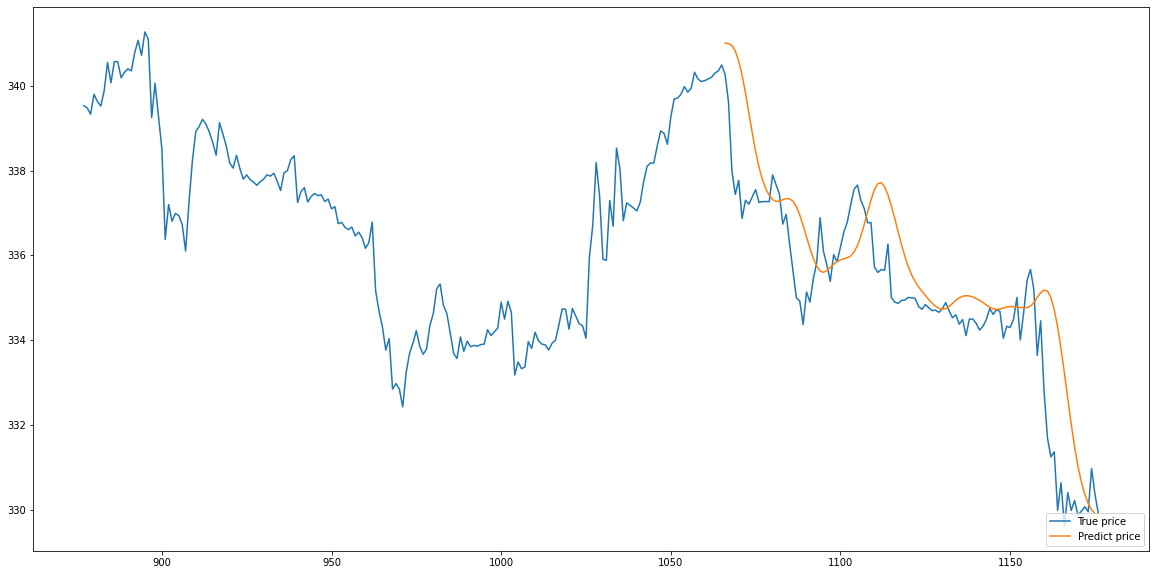

In [61]:
plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + SMA

Epoch 1/25
28/28 [==============================] - 5s 64ms/step - loss: 0.0349 - val_loss: 0.0140
Epoch 2/25
28/28 [==============================] - 1s 40ms/step - loss: 0.0106 - val_loss: 0.0038
Epoch 3/25
28/28 [==============================] - 1s 41ms/step - loss: 0.0081 - val_loss: 0.0033
Epoch 4/25
28/28 [==============================] - 1s 39ms/step - loss: 0.0067 - val_loss: 0.0030
Epoch 5/25
28/28 [==============================] - 1s 40ms/step - loss: 0.0064 - val_loss: 0.0021
Epoch 6/25
28/28 [==============================] - 1s 41ms/step - loss: 0.0067 - val_loss: 0.0041
Epoch 7/25
28/28 [==============================] - 1s 38ms/step - loss: 0.0054 - val_loss: 0.0028
Epoch 8/25
28/28 [==============================] - 1s 40ms/step - loss: 0.0063 - val_loss: 0.0074
Epoch 9/25
28/28 [==============================] - 1s 40ms/step - loss: 0.0064 - val_loss: 0.0019
Epoch 10/25
28/28 [==============================] - 1s 38ms/step - loss: 0.0047 - val_loss: 0.0016
Epoch 11/

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


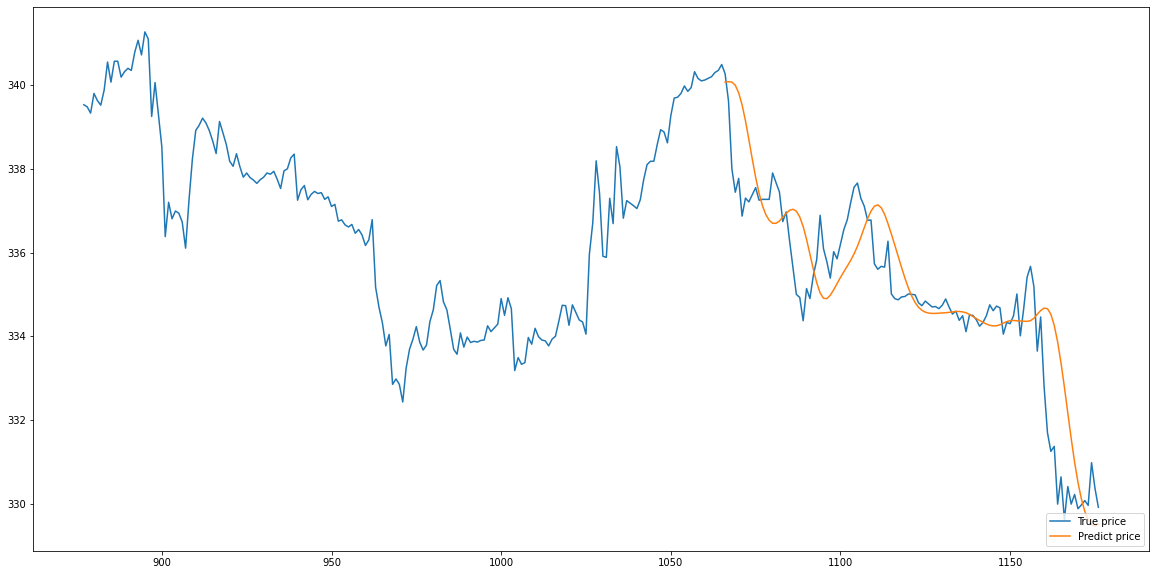

In [62]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_SMA.h5")

model_rnn = load_model('./MODEL/RNN_SMA.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + RSI

Epoch 1/25
28/28 [==============================] - 5s 64ms/step - loss: 0.0337 - val_loss: 0.0046
Epoch 2/25
28/28 [==============================] - 1s 42ms/step - loss: 0.0082 - val_loss: 0.0063
Epoch 3/25
28/28 [==============================] - 1s 39ms/step - loss: 0.0078 - val_loss: 0.0020
Epoch 4/25
28/28 [==============================] - 1s 41ms/step - loss: 0.0071 - val_loss: 0.0016
Epoch 5/25
28/28 [==============================] - 1s 39ms/step - loss: 0.0067 - val_loss: 0.0052
Epoch 6/25
28/28 [==============================] - 1s 40ms/step - loss: 0.0056 - val_loss: 0.0012
Epoch 7/25
28/28 [==============================] - 1s 41ms/step - loss: 0.0049 - val_loss: 0.0015
Epoch 8/25
28/28 [==============================] - 1s 38ms/step - loss: 0.0054 - val_loss: 0.0019
Epoch 9/25
28/28 [==============================] - 1s 40ms/step - loss: 0.0054 - val_loss: 0.0011
Epoch 10/25
28/28 [==============================] - 1s 40ms/step - loss: 0.0056 - val_loss: 0.0020
Epoch 11/

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


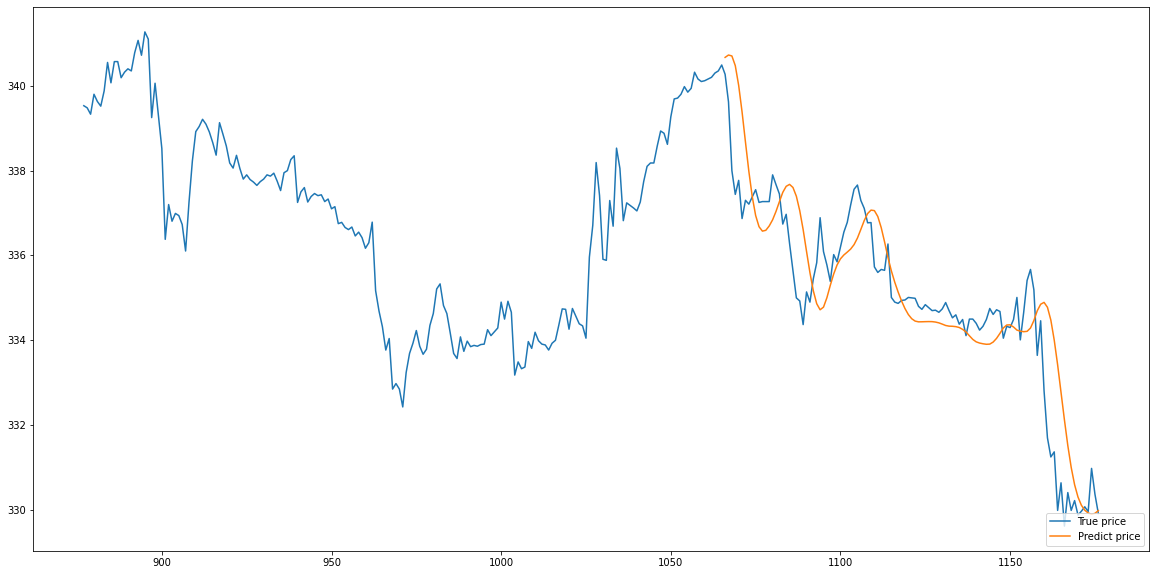

In [63]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'RSI']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_RSI.h5")

model_rnn = load_model('./MODEL/RNN_RSI.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS

Epoch 1/25
28/28 [==============================] - 5s 62ms/step - loss: 0.0334 - val_loss: 0.0048
Epoch 2/25
28/28 [==============================] - 1s 41ms/step - loss: 0.0106 - val_loss: 0.0043
Epoch 3/25
28/28 [==============================] - 1s 40ms/step - loss: 0.0083 - val_loss: 0.0030
Epoch 4/25
28/28 [==============================] - 1s 40ms/step - loss: 0.0079 - val_loss: 0.0032
Epoch 5/25
28/28 [==============================] - 1s 40ms/step - loss: 0.0074 - val_loss: 0.0027
Epoch 6/25
28/28 [==============================] - 1s 39ms/step - loss: 0.0067 - val_loss: 0.0039
Epoch 7/25
28/28 [==============================] - 1s 39ms/step - loss: 0.0093 - val_loss: 0.0035
Epoch 8/25
28/28 [==============================] - 1s 40ms/step - loss: 0.0069 - val_loss: 0.0029
Epoch 9/25
28/28 [==============================] - 1s 38ms/step - loss: 0.0056 - val_loss: 0.0018
Epoch 10/25
28/28 [==============================] - 1s 39ms/step - loss: 0.0054 - val_loss: 0.0018
Epoch 11/

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


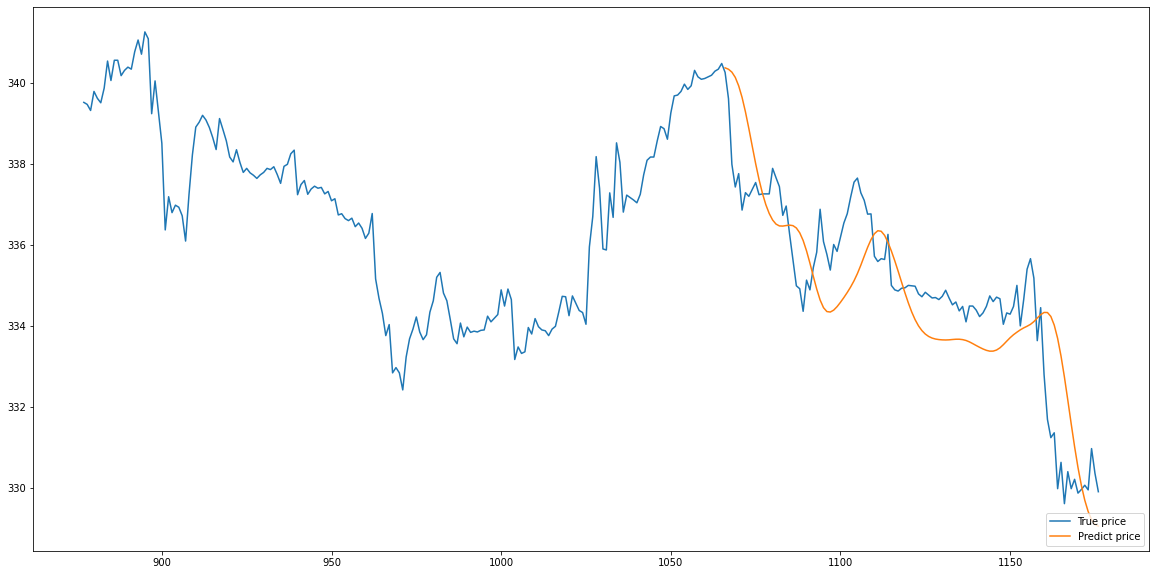

In [64]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_BBANDS.h5")

model_rnn = load_model('./MODEL/RNN_BBANDS.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + ROC

Epoch 1/25
28/28 [==============================] - 5s 66ms/step - loss: 0.0324 - val_loss: 0.0067
Epoch 2/25
28/28 [==============================] - 1s 39ms/step - loss: 0.0113 - val_loss: 0.0031
Epoch 3/25
28/28 [==============================] - 1s 40ms/step - loss: 0.0078 - val_loss: 0.0023
Epoch 4/25
28/28 [==============================] - 1s 39ms/step - loss: 0.0074 - val_loss: 0.0053
Epoch 5/25
28/28 [==============================] - 1s 39ms/step - loss: 0.0062 - val_loss: 0.0019
Epoch 6/25
28/28 [==============================] - 1s 40ms/step - loss: 0.0055 - val_loss: 0.0022
Epoch 7/25
28/28 [==============================] - 1s 39ms/step - loss: 0.0061 - val_loss: 0.0033
Epoch 8/25
28/28 [==============================] - 1s 40ms/step - loss: 0.0057 - val_loss: 0.0018
Epoch 9/25
28/28 [==============================] - 1s 40ms/step - loss: 0.0052 - val_loss: 0.0016
Epoch 10/25
28/28 [==============================] - 1s 38ms/step - loss: 0.0053 - val_loss: 0.0018
Epoch 11/

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


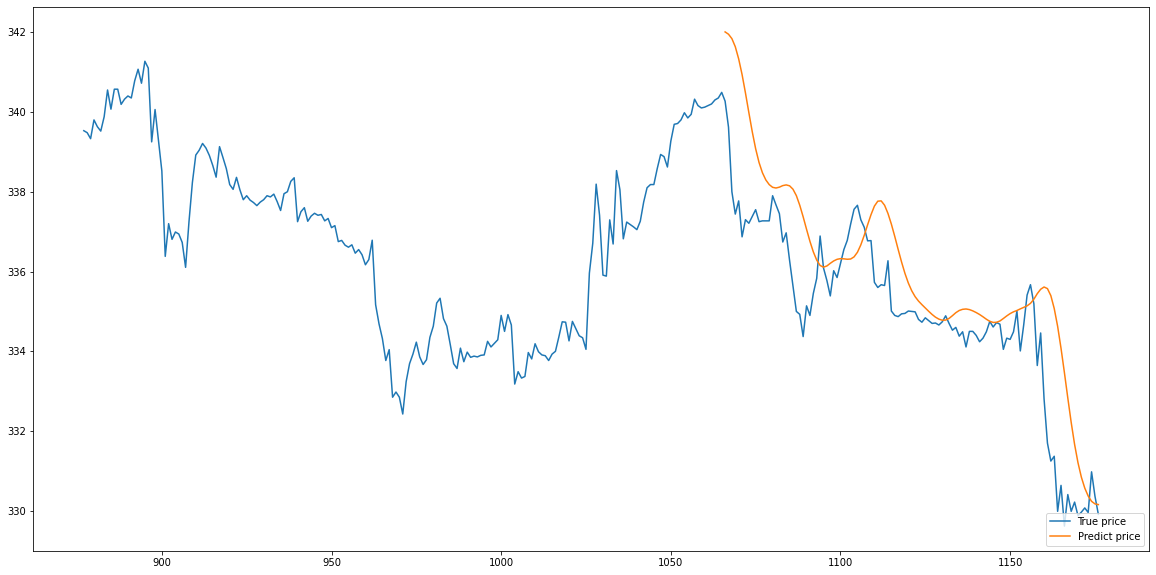

In [65]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_BBANDS_ROC.h5")

model_rnn = load_model('./MODEL/RNN_BBANDS_ROC.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + RSI

Epoch 1/25
28/28 [==============================] - 5s 60ms/step - loss: 0.0329 - val_loss: 0.0040
Epoch 2/25
28/28 [==============================] - 1s 41ms/step - loss: 0.0093 - val_loss: 0.0074
Epoch 3/25
28/28 [==============================] - 1s 40ms/step - loss: 0.0075 - val_loss: 0.0036
Epoch 4/25
28/28 [==============================] - 1s 42ms/step - loss: 0.0063 - val_loss: 0.0019
Epoch 5/25
28/28 [==============================] - 1s 40ms/step - loss: 0.0062 - val_loss: 0.0014
Epoch 6/25
28/28 [==============================] - 1s 40ms/step - loss: 0.0069 - val_loss: 0.0020
Epoch 7/25
28/28 [==============================] - 1s 42ms/step - loss: 0.0058 - val_loss: 0.0014
Epoch 8/25
28/28 [==============================] - 1s 40ms/step - loss: 0.0050 - val_loss: 0.0015
Epoch 9/25
28/28 [==============================] - 1s 43ms/step - loss: 0.0050 - val_loss: 0.0025
Epoch 10/25
28/28 [==============================] - 1s 41ms/step - loss: 0.0045 - val_loss: 0.0017
Epoch 11/

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


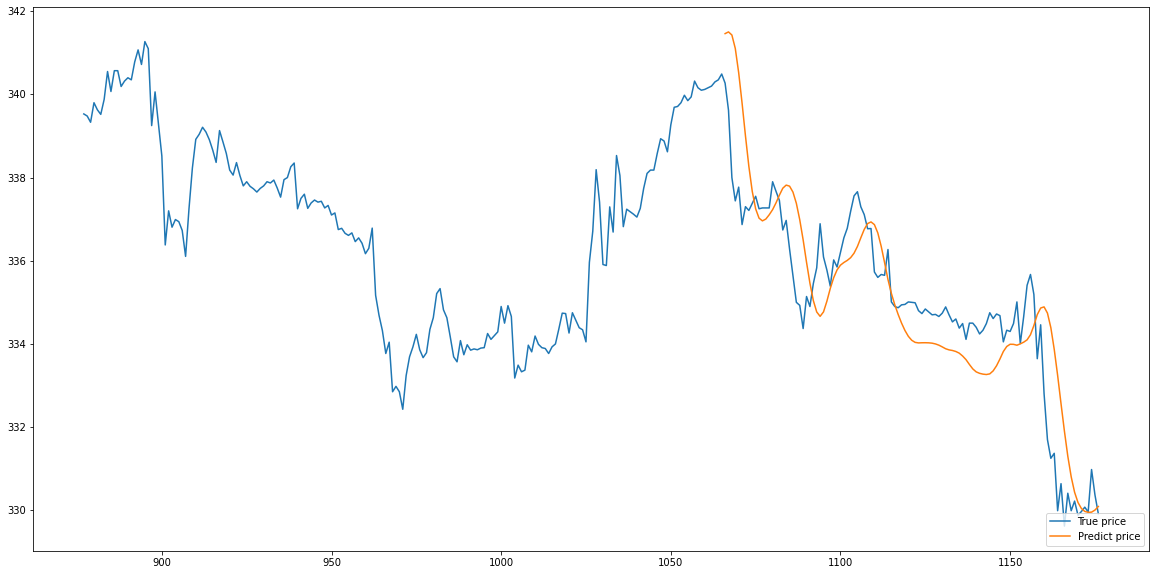

In [66]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'RSI']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_BBANDS_RSI.h5")

model_rnn = load_model('./MODEL/RNN_BBANDS_RSI.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + SMA

Epoch 1/25
28/28 [==============================] - 4s 64ms/step - loss: 0.0375 - val_loss: 0.0060
Epoch 2/25
28/28 [==============================] - 1s 41ms/step - loss: 0.0105 - val_loss: 0.0047
Epoch 3/25
28/28 [==============================] - 1s 42ms/step - loss: 0.0090 - val_loss: 0.0041
Epoch 4/25
28/28 [==============================] - 1s 39ms/step - loss: 0.0081 - val_loss: 0.0048
Epoch 5/25
28/28 [==============================] - 1s 42ms/step - loss: 0.0068 - val_loss: 0.0021
Epoch 6/25
28/28 [==============================] - 1s 40ms/step - loss: 0.0071 - val_loss: 0.0034
Epoch 7/25
28/28 [==============================] - 1s 41ms/step - loss: 0.0062 - val_loss: 0.0025
Epoch 8/25
28/28 [==============================] - 1s 42ms/step - loss: 0.0059 - val_loss: 0.0025
Epoch 9/25
28/28 [==============================] - 1s 39ms/step - loss: 0.0056 - val_loss: 0.0023
Epoch 10/25
28/28 [==============================] - 1s 42ms/step - loss: 0.0056 - val_loss: 0.0024
Epoch 11/

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


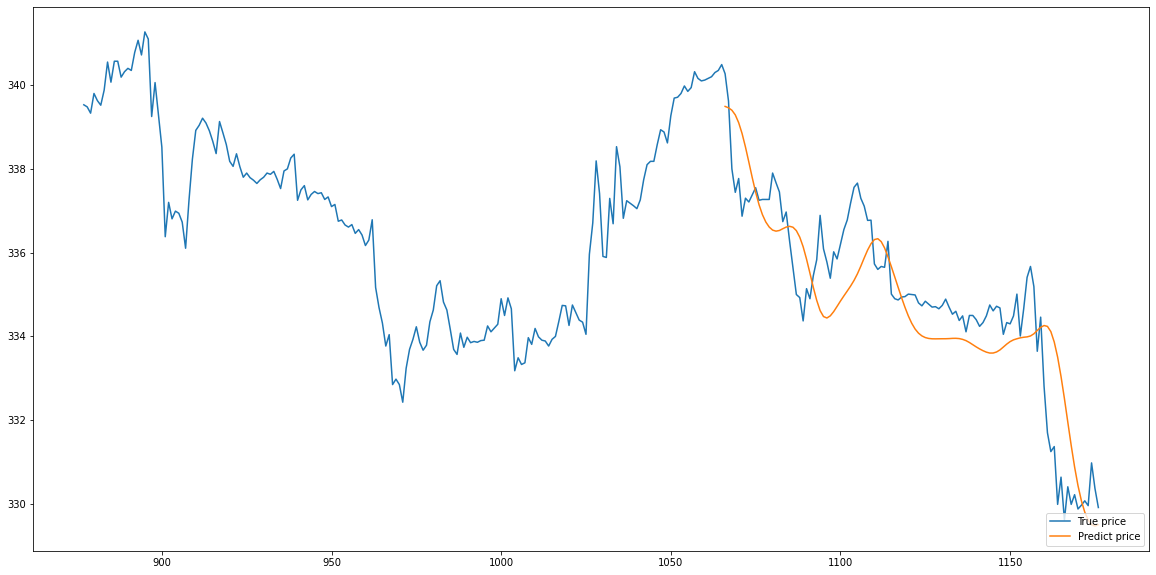

In [67]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_BBANDS_SMA.h5")

model_rnn = load_model('./MODEL/RNN_BBANDS_SMA.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + ROC + RSI

Epoch 1/25
28/28 [==============================] - 5s 64ms/step - loss: 0.0369 - val_loss: 0.0045
Epoch 2/25
28/28 [==============================] - 1s 40ms/step - loss: 0.0079 - val_loss: 0.0021
Epoch 3/25
28/28 [==============================] - 1s 40ms/step - loss: 0.0076 - val_loss: 0.0017
Epoch 4/25
28/28 [==============================] - 1s 39ms/step - loss: 0.0061 - val_loss: 0.0027
Epoch 5/25
28/28 [==============================] - 1s 39ms/step - loss: 0.0057 - val_loss: 0.0026
Epoch 6/25
28/28 [==============================] - 1s 40ms/step - loss: 0.0062 - val_loss: 0.0020
Epoch 7/25
28/28 [==============================] - 1s 39ms/step - loss: 0.0054 - val_loss: 0.0033
Epoch 8/25
28/28 [==============================] - 1s 40ms/step - loss: 0.0058 - val_loss: 0.0028
Epoch 9/25
28/28 [==============================] - 1s 39ms/step - loss: 0.0058 - val_loss: 0.0042
Epoch 10/25
28/28 [==============================] - 1s 38ms/step - loss: 0.0052 - val_loss: 0.0015
Epoch 11/

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


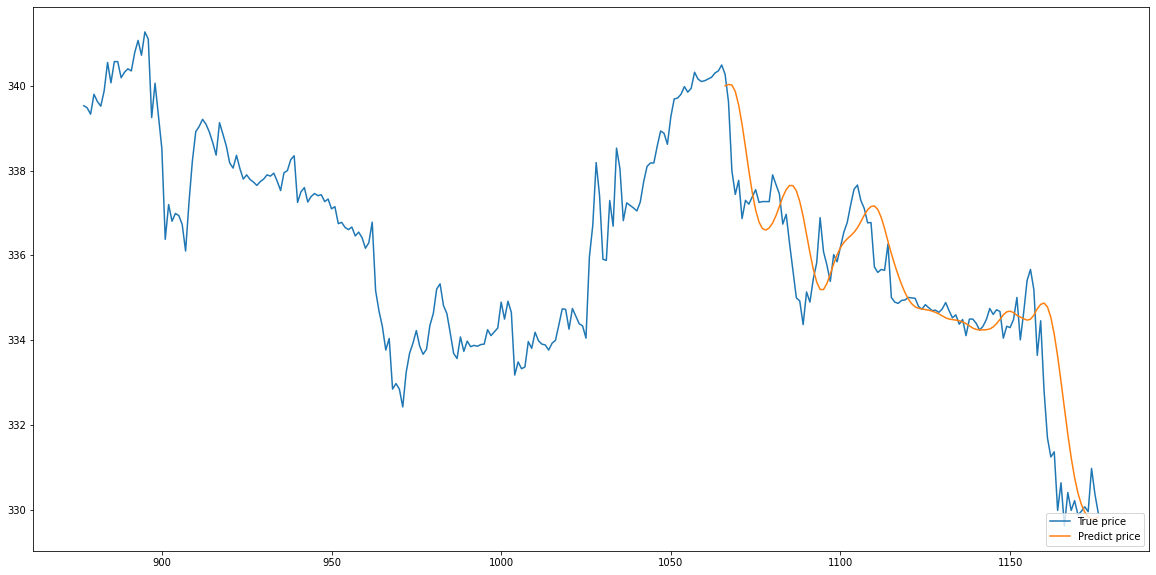

In [68]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'ROC', 'RSI']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_ROC_RSI.h5")

model_rnn = load_model('./MODEL/RNN_ROC_RSI.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + ROC + SMA

Epoch 1/25
28/28 [==============================] - 5s 70ms/step - loss: 0.0341 - val_loss: 0.0083
Epoch 2/25
28/28 [==============================] - 1s 42ms/step - loss: 0.0089 - val_loss: 0.0039
Epoch 3/25
28/28 [==============================] - 1s 39ms/step - loss: 0.0075 - val_loss: 0.0033
Epoch 4/25
28/28 [==============================] - 1s 41ms/step - loss: 0.0062 - val_loss: 0.0032
Epoch 5/25
28/28 [==============================] - 1s 39ms/step - loss: 0.0061 - val_loss: 0.0030
Epoch 6/25
28/28 [==============================] - 1s 40ms/step - loss: 0.0060 - val_loss: 0.0023
Epoch 7/25
28/28 [==============================] - 1s 41ms/step - loss: 0.0061 - val_loss: 0.0017
Epoch 8/25
28/28 [==============================] - 1s 38ms/step - loss: 0.0057 - val_loss: 0.0016
Epoch 9/25
28/28 [==============================] - 1s 40ms/step - loss: 0.0054 - val_loss: 0.0046
Epoch 10/25
28/28 [==============================] - 1s 39ms/step - loss: 0.0054 - val_loss: 0.0028
Epoch 11/

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


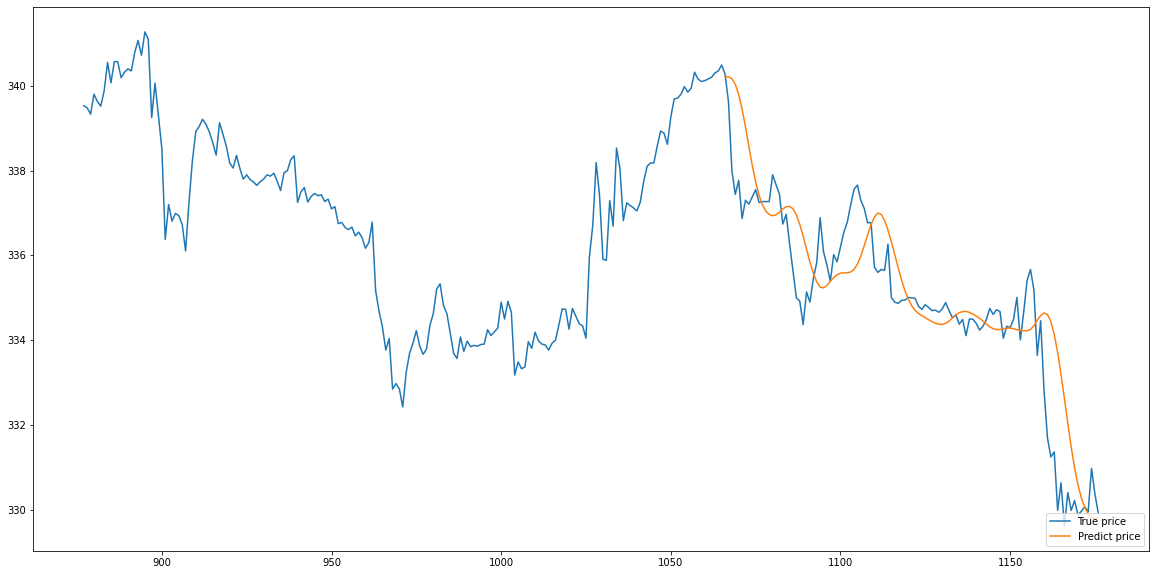

In [69]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'ROC', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_ROC_SMA.h5")

model_rnn = load_model('./MODEL/RNN_ROC_SMA.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + RSI + SMA

Epoch 1/25
28/28 [==============================] - 5s 63ms/step - loss: 0.0345 - val_loss: 0.0090
Epoch 2/25
28/28 [==============================] - 1s 42ms/step - loss: 0.0085 - val_loss: 0.0025
Epoch 3/25
28/28 [==============================] - 1s 42ms/step - loss: 0.0063 - val_loss: 0.0036
Epoch 4/25
28/28 [==============================] - 1s 39ms/step - loss: 0.0059 - val_loss: 0.0028
Epoch 5/25
28/28 [==============================] - 1s 42ms/step - loss: 0.0055 - val_loss: 0.0014
Epoch 6/25
28/28 [==============================] - 1s 40ms/step - loss: 0.0054 - val_loss: 0.0028
Epoch 7/25
28/28 [==============================] - 1s 40ms/step - loss: 0.0052 - val_loss: 0.0012
Epoch 8/25
28/28 [==============================] - 1s 41ms/step - loss: 0.0054 - val_loss: 0.0013
Epoch 9/25
28/28 [==============================] - 1s 39ms/step - loss: 0.0052 - val_loss: 0.0013
Epoch 10/25
28/28 [==============================] - 1s 42ms/step - loss: 0.0046 - val_loss: 0.0013
Epoch 11/

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


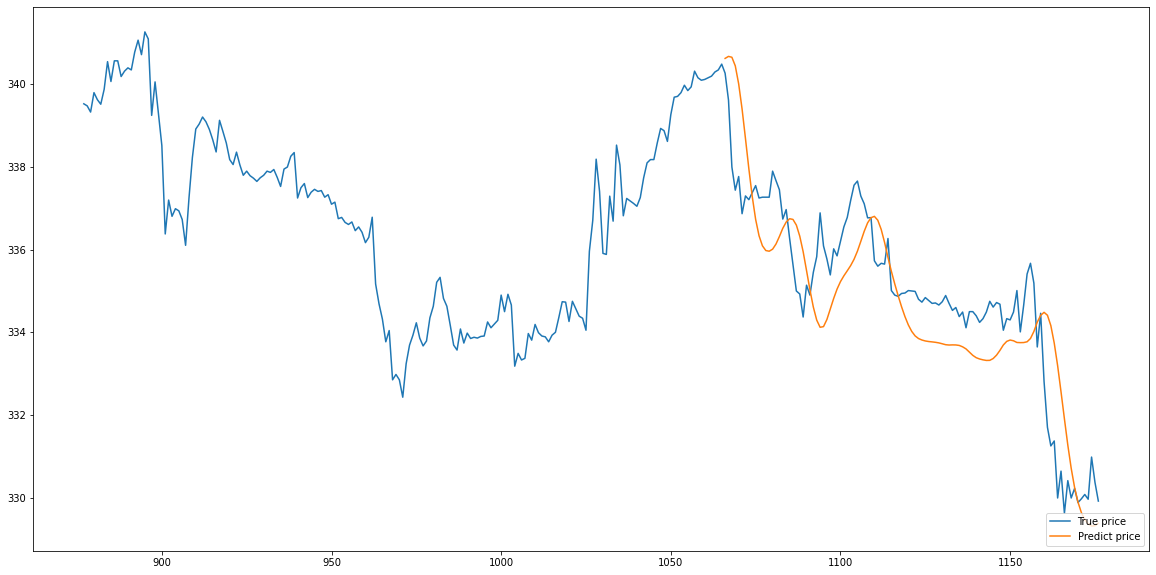

In [70]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'RSI', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_RSI_SMA.h5")

model_rnn = load_model('./MODEL/RNN_RSI_SMA.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + ROC + RSI

Epoch 1/25
28/28 [==============================] - 5s 65ms/step - loss: 0.0378 - val_loss: 0.0039
Epoch 2/25
28/28 [==============================] - 1s 39ms/step - loss: 0.0082 - val_loss: 0.0042
Epoch 3/25
28/28 [==============================] - 1s 42ms/step - loss: 0.0071 - val_loss: 0.0017
Epoch 4/25
28/28 [==============================] - 1s 41ms/step - loss: 0.0061 - val_loss: 0.0019
Epoch 5/25
28/28 [==============================] - 1s 41ms/step - loss: 0.0056 - val_loss: 0.0022
Epoch 6/25
28/28 [==============================] - 1s 42ms/step - loss: 0.0052 - val_loss: 0.0022
Epoch 7/25
28/28 [==============================] - 1s 39ms/step - loss: 0.0053 - val_loss: 0.0017
Epoch 8/25
28/28 [==============================] - 1s 42ms/step - loss: 0.0054 - val_loss: 0.0029
Epoch 9/25
28/28 [==============================] - 1s 40ms/step - loss: 0.0049 - val_loss: 0.0012
Epoch 10/25
28/28 [==============================] - 1s 41ms/step - loss: 0.0051 - val_loss: 0.0012
Epoch 11/

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


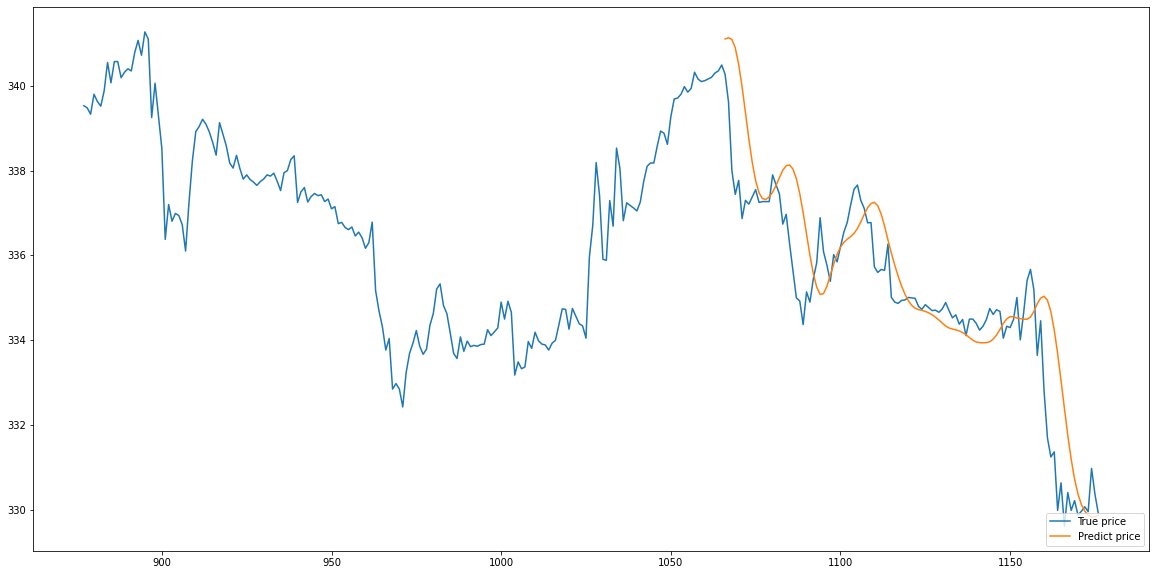

In [71]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'RSI']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_BBANDS_ROC_RSI.h5")

model_rnn = load_model('./MODEL/RNN_BBANDS_ROC_RSI.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + ROC + SMA

Epoch 1/25
28/28 [==============================] - 5s 64ms/step - loss: 0.0347 - val_loss: 0.0067
Epoch 2/25
28/28 [==============================] - 1s 42ms/step - loss: 0.0098 - val_loss: 0.0046
Epoch 3/25
28/28 [==============================] - 1s 40ms/step - loss: 0.0081 - val_loss: 0.0025
Epoch 4/25
28/28 [==============================] - 1s 41ms/step - loss: 0.0062 - val_loss: 0.0065
Epoch 5/25
28/28 [==============================] - 1s 39ms/step - loss: 0.0065 - val_loss: 0.0034
Epoch 6/25
28/28 [==============================] - 1s 42ms/step - loss: 0.0059 - val_loss: 0.0030
Epoch 7/25
28/28 [==============================] - 1s 41ms/step - loss: 0.0053 - val_loss: 0.0024
Epoch 8/25
28/28 [==============================] - 1s 40ms/step - loss: 0.0051 - val_loss: 0.0017
Epoch 9/25
28/28 [==============================] - 1s 42ms/step - loss: 0.0053 - val_loss: 0.0022
Epoch 10/25
28/28 [==============================] - 1s 39ms/step - loss: 0.0050 - val_loss: 0.0019
Epoch 11/

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


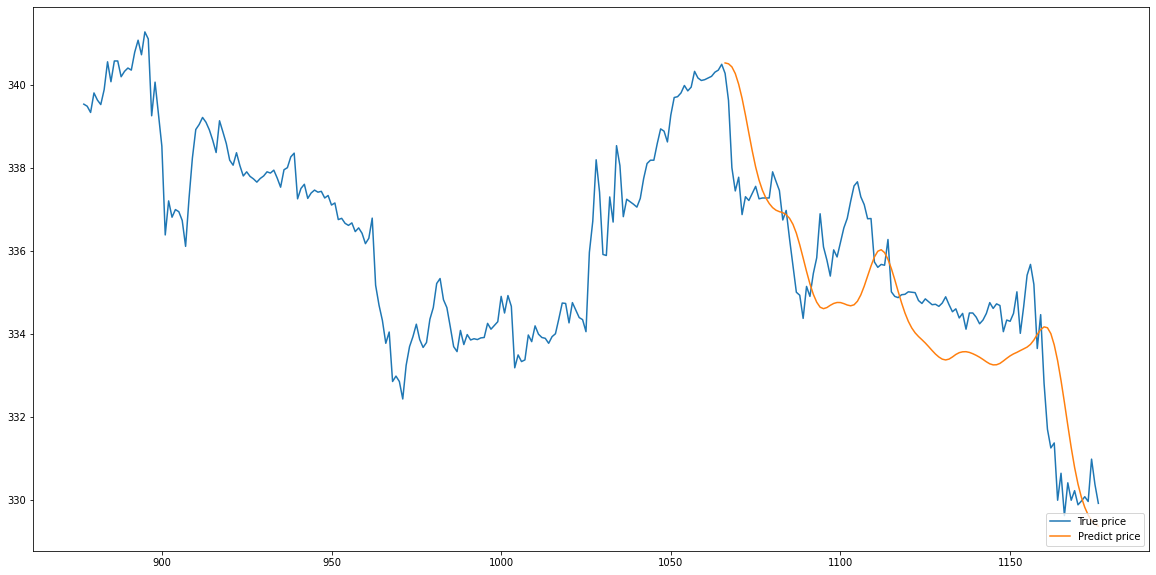

In [72]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_BBANDS_ROC_SMA.h5")

model_rnn = load_model('./MODEL/RNN_BBANDS_ROC_SMA.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + RSI + SMA

Epoch 1/25
28/28 [==============================] - 5s 64ms/step - loss: 0.0347 - val_loss: 0.0043
Epoch 2/25
28/28 [==============================] - 1s 42ms/step - loss: 0.0079 - val_loss: 0.0026
Epoch 3/25
28/28 [==============================] - 1s 38ms/step - loss: 0.0072 - val_loss: 0.0017
Epoch 4/25
28/28 [==============================] - 1s 41ms/step - loss: 0.0070 - val_loss: 0.0016
Epoch 5/25
28/28 [==============================] - 1s 40ms/step - loss: 0.0067 - val_loss: 0.0018
Epoch 6/25
28/28 [==============================] - 1s 40ms/step - loss: 0.0064 - val_loss: 0.0014
Epoch 7/25
28/28 [==============================] - 1s 40ms/step - loss: 0.0046 - val_loss: 0.0046
Epoch 8/25
28/28 [==============================] - 1s 38ms/step - loss: 0.0051 - val_loss: 0.0036
Epoch 9/25
28/28 [==============================] - 1s 40ms/step - loss: 0.0050 - val_loss: 0.0018
Epoch 10/25
28/28 [==============================] - 1s 40ms/step - loss: 0.0050 - val_loss: 0.0014
Epoch 11/

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


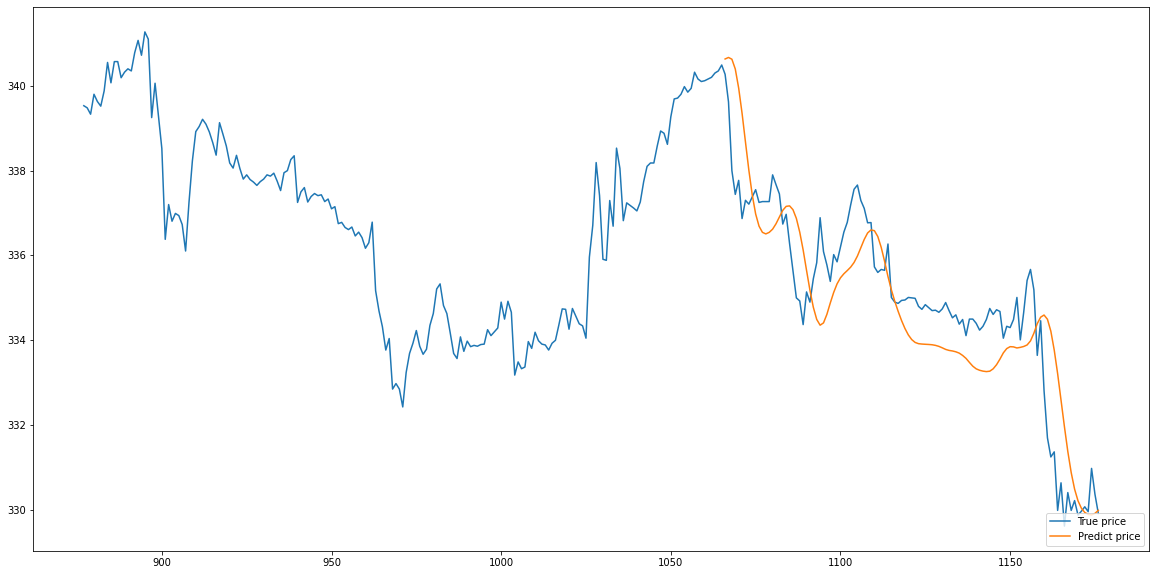

In [73]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'RSI', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_BBANDS_RSI_SMA.h5")

model_rnn = load_model('./MODEL/RNN_BBANDS_RSI_SMA.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + ROC + RSI + SMA

Epoch 1/25
28/28 [==============================] - 5s 65ms/step - loss: 0.0319 - val_loss: 0.0042
Epoch 2/25
28/28 [==============================] - 1s 41ms/step - loss: 0.0077 - val_loss: 0.0025
Epoch 3/25
28/28 [==============================] - 1s 42ms/step - loss: 0.0061 - val_loss: 0.0014
Epoch 4/25
28/28 [==============================] - 1s 40ms/step - loss: 0.0059 - val_loss: 0.0020
Epoch 5/25
28/28 [==============================] - 1s 41ms/step - loss: 0.0058 - val_loss: 0.0015
Epoch 6/25
28/28 [==============================] - 1s 41ms/step - loss: 0.0052 - val_loss: 0.0016
Epoch 7/25
28/28 [==============================] - 1s 40ms/step - loss: 0.0048 - val_loss: 0.0012
Epoch 8/25
28/28 [==============================] - 1s 41ms/step - loss: 0.0053 - val_loss: 0.0015
Epoch 9/25
28/28 [==============================] - 1s 39ms/step - loss: 0.0043 - val_loss: 0.0013
Epoch 10/25
28/28 [==============================] - 1s 41ms/step - loss: 0.0043 - val_loss: 9.8906e-04
Epoch

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


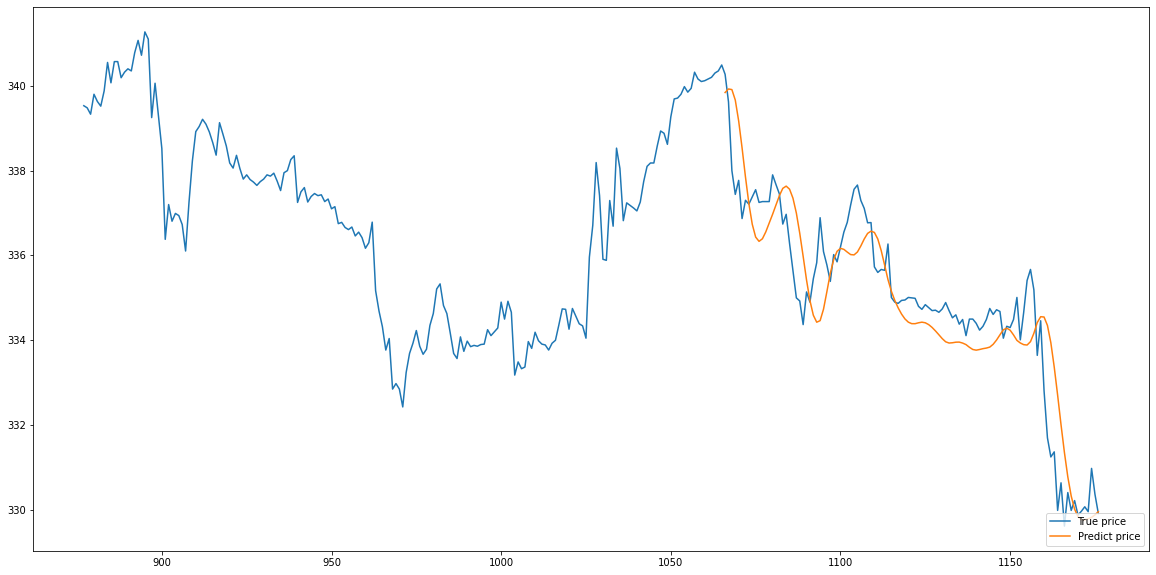

In [74]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'ROC', 'RSI', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_ROC_RSI_SMA.h5")

model_rnn = load_model('./MODEL/RNN_ROC_RSI_SMA.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + ROC + RSI + SMA

Epoch 1/25
28/28 [==============================] - 5s 64ms/step - loss: 0.0373 - val_loss: 0.0043
Epoch 2/25
28/28 [==============================] - 1s 38ms/step - loss: 0.0100 - val_loss: 0.0019
Epoch 3/25
28/28 [==============================] - 1s 44ms/step - loss: 0.0075 - val_loss: 0.0038
Epoch 4/25
28/28 [==============================] - 1s 41ms/step - loss: 0.0069 - val_loss: 0.0014
Epoch 5/25
28/28 [==============================] - 1s 39ms/step - loss: 0.0068 - val_loss: 0.0012
Epoch 6/25
28/28 [==============================] - 1s 41ms/step - loss: 0.0063 - val_loss: 0.0021
Epoch 7/25
28/28 [==============================] - 1s 40ms/step - loss: 0.0060 - val_loss: 0.0027
Epoch 8/25
28/28 [==============================] - 1s 41ms/step - loss: 0.0056 - val_loss: 0.0013
Epoch 9/25
28/28 [==============================] - 1s 41ms/step - loss: 0.0053 - val_loss: 0.0027
Epoch 10/25
28/28 [==============================] - 1s 38ms/step - loss: 0.0048 - val_loss: 0.0018
Epoch 11/

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


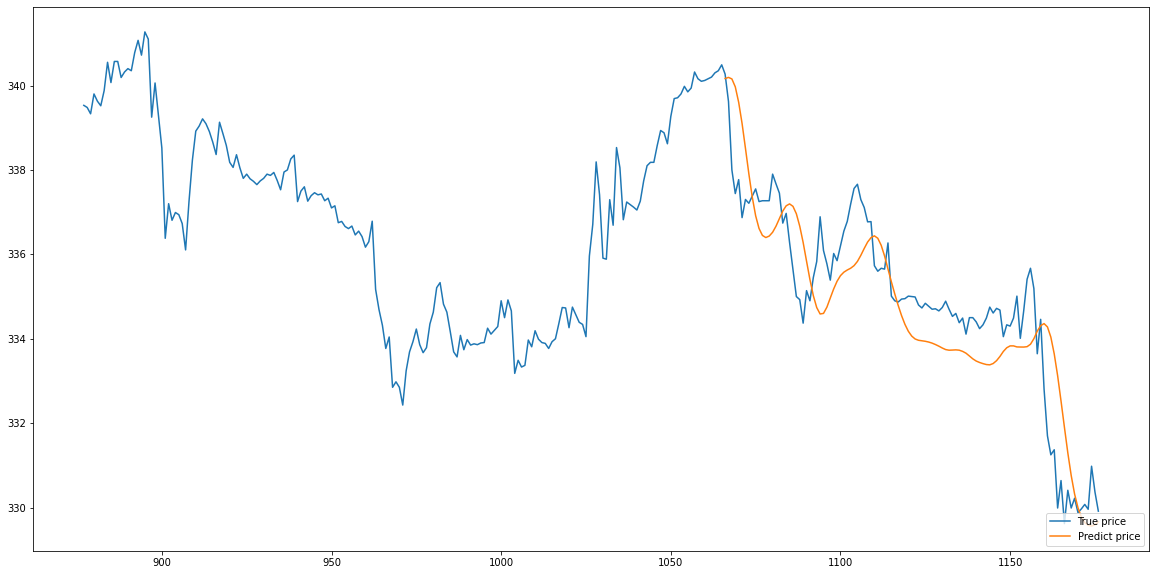

In [75]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'RSI', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_BBANDS_ROC_RSI_SMA.h5")

model_rnn = load_model('./MODEL/RNN_BBANDS_ROC_RSI_SMA.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

## 3. XGBOOST

### a. Prepare Input

In [76]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume']]
dataset

close     volume
0     336.720    36329.0
1     335.210    99194.0
2     335.530  4039489.0
3     331.850  2107766.0
4     331.150  1311465.0
...       ...        ...
1172  330.075   445942.0
1173  329.960   366852.0
1174  330.980   467913.0
1175  330.370   363906.0
1176  329.915   478434.0

[1177 rows x 2 columns]

In [77]:
for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
dataset

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


close     volume  close_date_1  volume_date_1  close_date_2  \
0     336.720    36329.0           NaN            NaN           NaN   
1     335.210    99194.0       336.720        36329.0           NaN   
2     335.530  4039489.0       335.210        99194.0       336.720   
3     331.850  2107766.0       335.530      4039489.0       335.210   
4     331.150  1311465.0       331.850      2107766.0       335.530   
...       ...        ...           ...            ...           ...   
1172  330.075   445942.0       329.970       371846.0       329.880   
1173  329.960   366852.0       330.075       445942.0       329.970   
1174  330.980   467913.0       329.960       366852.0       330.075   
1175  330.370   363906.0       330.980       467913.0       329.960   
1176  329.915   478434.0       330.370       363906.0       330.980   

      volume_date_2  
0               NaN  
1               NaN  
2           36329.0  
3           99194.0  
4         4039489.0  
...             ...  
1172       423327.0  
1173       371846.0  
1174       445942.0  
1175       366852.0  
1176       467913.0  

[1177 rows x 6 columns]

In [78]:
dataset.dropna(inplace=True)
dataset

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


close     volume  close_date_1  volume_date_1  close_date_2  \
2     335.530  4039489.0       335.210        99194.0       336.720   
3     331.850  2107766.0       335.530      4039489.0       335.210   
4     331.150  1311465.0       331.850      2107766.0       335.530   
5     331.841  1194555.0       331.150      1311465.0       331.850   
6     332.650   958524.0       331.841      1194555.0       331.150   
...       ...        ...           ...            ...           ...   
1172  330.075   445942.0       329.970       371846.0       329.880   
1173  329.960   366852.0       330.075       445942.0       329.970   
1174  330.980   467913.0       329.960       366852.0       330.075   
1175  330.370   363906.0       330.980       467913.0       329.960   
1176  329.915   478434.0       330.370       363906.0       330.980   

      volume_date_2  
2           36329.0  
3           99194.0  
4         4039489.0  
5         2107766.0  
6         1311465.0  
...             ...  
1172       423327.0  
1173       371846.0  
1174       445942.0  
1175       366852.0  
1176       467913.0  

[1175 rows x 6 columns]

In [79]:
X = dataset.drop(['close', 'volume'], axis=1)
y = pd.DataFrame(dataset['close'])
print(X.shape)
print(y.shape)
X

(1175, 4)
(1175, 1)


close_date_1  volume_date_1  close_date_2  volume_date_2
2          335.210        99194.0       336.720        36329.0
3          335.530      4039489.0       335.210        99194.0
4          331.850      2107766.0       335.530      4039489.0
5          331.150      1311465.0       331.850      2107766.0
6          331.841      1194555.0       331.150      1311465.0
...            ...            ...           ...            ...
1172       329.970       371846.0       329.880       423327.0
1173       330.075       445942.0       329.970       371846.0
1174       329.960       366852.0       330.075       445942.0
1175       330.980       467913.0       329.960       366852.0
1176       330.370       363906.0       330.980       467913.0

[1175 rows x 4 columns]

In [80]:
X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]
print("Size train: ", X_train.shape)
print("Size test: ", X_test.shape)

Size train:  (1058, 4)
Size test:  (117, 4)


### b. Train Model

In [81]:
xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST.dat", "wb"))

### c. Test Model

In [82]:
model_xgboost = pickle.load(open("./MODEL/XGBOOST.dat", "rb"))

In [83]:
predictions = model_xgboost.predict(X_test)
predictions

array([339.87018, 339.91617, 339.8929 , 340.5455 , 340.59906, 340.63177,
       340.6441 , 340.4749 , 339.8332 , 337.721  , 337.3311 , 337.52695,
       336.68924, 337.24936, 337.0206 , 337.08795, 337.41336, 337.239  ,
       337.09775, 337.1111 , 337.16125, 337.43317, 337.69647, 337.4488 ,
       336.69928, 337.58698, 336.54364, 336.11884, 335.5822 , 334.88147,
       334.79095, 334.35324, 334.19092, 335.33838, 335.68936, 336.58002,
       336.84164, 335.93973, 335.3598 , 335.7609 , 336.07166, 336.27576,
       336.67053, 336.63354, 337.08316, 337.39636, 337.5982 , 337.1899 ,
       337.141  , 336.79843, 336.59958, 336.034  , 335.62143, 335.59607,
       335.6488 , 336.13092, 335.10092, 334.1481 , 334.5133 , 334.66705,
       334.8276 , 335.39624, 335.0756 , 335.3257 , 334.4438 , 334.79352,
       334.763  , 334.52542, 334.45108, 334.5255 , 334.3476 , 334.4661 ,
       334.37762, 334.72562, 334.55475, 334.4935 , 334.46756, 334.5774 ,
       333.9497 , 334.61197, 334.5595 , 334.49634, 

In [84]:
prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions
prediction_df

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


close    volume  close_date_1  volume_date_1  close_date_2  \
1060  340.120    2379.0       340.100         3287.0       340.160   
1061  340.160    1581.0       340.120         2379.0       340.100   
1062  340.200    2106.0       340.160         1581.0       340.120   
1063  340.300    4588.0       340.200         2106.0       340.160   
1064  340.350    4269.0       340.300         4588.0       340.200   
...       ...       ...           ...            ...           ...   
1172  330.075  445942.0       329.970       371846.0       329.880   
1173  329.960  366852.0       330.075       445942.0       329.970   
1174  330.980  467913.0       329.960       366852.0       330.075   
1175  330.370  363906.0       330.980       467913.0       329.960   
1176  329.915  478434.0       330.370       363906.0       330.980   

      volume_date_2  predictions  
1060         5831.0   339.870178  
1061         3287.0   339.916168  
1062         2379.0   339.892914  
1063         1581.0   340.545502  
1064         2106.0   340.599060  
...             ...          ...  
1172       423327.0   329.458160  
1173       371846.0   329.308319  
1174       445942.0   329.395294  
1175       366852.0   331.572357  
1176       467913.0   330.167999  

[117 rows x 7 columns]

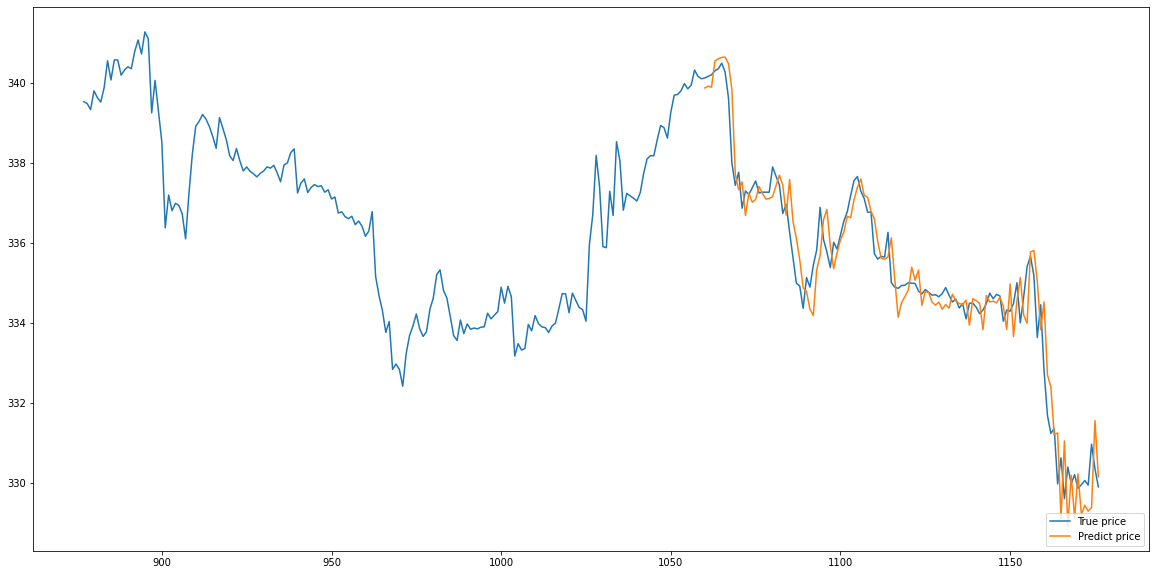

In [85]:
plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

### d. Combine Indicators

#### + ROC

In [86]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'ROC']]
dataset

close     volume     ROC
0     336.720    36329.0  0.3038
1     335.210    99194.0 -0.3893
2     335.530  4039489.0 -0.4864
3     331.850  2107766.0 -1.3555
4     331.150  1311465.0 -1.5460
...       ...        ...     ...
1172  330.075   445942.0 -1.4731
1173  329.960   366852.0 -1.2125
1174  330.980   467913.0 -1.0996
1175  330.370   363906.0 -1.5026
1176  329.915   478434.0 -1.7145

[1177 rows x 3 columns]

In [87]:
for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["ROC_date_" + str(i)] = dataset.ROC.shift(i)
dataset

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


close     volume     ROC  close_date_1  volume_date_1  ROC_date_1  \
0     336.720    36329.0  0.3038           NaN            NaN         NaN   
1     335.210    99194.0 -0.3893       336.720        36329.0      0.3038   
2     335.530  4039489.0 -0.4864       335.210        99194.0     -0.3893   
3     331.850  2107766.0 -1.3555       335.530      4039489.0     -0.4864   
4     331.150  1311465.0 -1.5460       331.850      2107766.0     -1.3555   
...       ...        ...     ...           ...            ...         ...   
1172  330.075   445942.0 -1.4731       329.970       371846.0     -1.3513   
1173  329.960   366852.0 -1.2125       330.075       445942.0     -1.4731   
1174  330.980   467913.0 -1.0996       329.960       366852.0     -1.2125   
1175  330.370   363906.0 -1.5026       330.980       467913.0     -1.0996   
1176  329.915   478434.0 -1.7145       330.370       363906.0     -1.5026   

      close_date_2  volume_date_2  ROC_date_2  
0              NaN            NaN         NaN  
1              NaN            NaN         NaN  
2          336.720        36329.0      0.3038  
3          335.210        99194.0     -0.3893  
4          335.530      4039489.0     -0.4864  
...            ...            ...         ...  
1172       329.880       423327.0     -1.3222  
1173       329.970       371846.0     -1.3513  
1174       330.075       445942.0     -1.4731  
1175       329.960       366852.0     -1.2125  
1176       330.980       467913.0     -1.0996  

[1177 rows x 9 columns]

In [88]:
dataset.dropna(inplace=True)
dataset

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


close     volume     ROC  close_date_1  volume_date_1  ROC_date_1  \
2     335.530  4039489.0 -0.4864       335.210        99194.0     -0.3893   
3     331.850  2107766.0 -1.3555       335.530      4039489.0     -0.4864   
4     331.150  1311465.0 -1.5460       331.850      2107766.0     -1.3555   
5     331.841  1194555.0 -1.2437       331.150      1311465.0     -1.5460   
6     332.650   958524.0 -1.1147       331.841      1194555.0     -1.2437   
...       ...        ...     ...           ...            ...         ...   
1172  330.075   445942.0 -1.4731       329.970       371846.0     -1.3513   
1173  329.960   366852.0 -1.2125       330.075       445942.0     -1.4731   
1174  330.980   467913.0 -1.0996       329.960       366852.0     -1.2125   
1175  330.370   363906.0 -1.5026       330.980       467913.0     -1.0996   
1176  329.915   478434.0 -1.7145       330.370       363906.0     -1.5026   

      close_date_2  volume_date_2  ROC_date_2  
2          336.720        36329.0      0.3038  
3          335.210        99194.0     -0.3893  
4          335.530      4039489.0     -0.4864  
5          331.850      2107766.0     -1.3555  
6          331.150      1311465.0     -1.5460  
...            ...            ...         ...  
1172       329.880       423327.0     -1.3222  
1173       329.970       371846.0     -1.3513  
1174       330.075       445942.0     -1.4731  
1175       329.960       366852.0     -1.2125  
1176       330.980       467913.0     -1.0996  

[1175 rows x 9 columns]

In [89]:
X = dataset.drop(['close', 'volume', 'ROC'], axis=1)
y = pd.DataFrame(dataset['close'])
print(X.shape)
print(y.shape)
X

(1175, 6)
(1175, 1)


close_date_1  volume_date_1  ROC_date_1  close_date_2  volume_date_2  \
2          335.210        99194.0     -0.3893       336.720        36329.0   
3          335.530      4039489.0     -0.4864       335.210        99194.0   
4          331.850      2107766.0     -1.3555       335.530      4039489.0   
5          331.150      1311465.0     -1.5460       331.850      2107766.0   
6          331.841      1194555.0     -1.2437       331.150      1311465.0   
...            ...            ...         ...           ...            ...   
1172       329.970       371846.0     -1.3513       329.880       423327.0   
1173       330.075       445942.0     -1.4731       329.970       371846.0   
1174       329.960       366852.0     -1.2125       330.075       445942.0   
1175       330.980       467913.0     -1.0996       329.960       366852.0   
1176       330.370       363906.0     -1.5026       330.980       467913.0   

      ROC_date_2  
2         0.3038  
3        -0.3893  
4        -0.4864  
5        -1.3555  
6        -1.5460  
...          ...  
1172     -1.3222  
1173     -1.3513  
1174     -1.4731  
1175     -1.2125  
1176     -1.0996  

[1175 rows x 6 columns]

In [90]:
X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]
print("Size train: ", X_train.shape)
print("Size test: ", X_test.shape)

Size train:  (1058, 6)
Size test:  (117, 6)


In [91]:
xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_ROC.dat", "wb"))

In [92]:
model_xgboost = pickle.load(open("./MODEL/XGBOOST_ROC.dat", "rb"))

In [93]:
predictions = model_xgboost.predict(X_test)
predictions

array([339.8872 , 339.78778, 339.73315, 340.50827, 340.56464, 340.8253 ,
       340.8253 , 340.80667, 340.10406, 337.47504, 337.36395, 337.56772,
       336.5771 , 337.15137, 336.87833, 336.9244 , 337.11984, 337.01523,
       336.96338, 337.02704, 337.042  , 337.34695, 337.33377, 337.1438 ,
       336.69855, 337.03397, 336.43173, 336.05496, 335.33365, 334.85385,
       334.8719 , 334.48224, 334.49304, 335.80038, 335.74542, 336.37173,
       336.85205, 336.16846, 335.61874, 335.52292, 336.09454, 336.14023,
       336.6229 , 336.6935 , 337.33667, 337.6679 , 337.56998, 337.4045 ,
       337.22723, 336.65555, 336.81287, 336.16544, 335.68747, 335.68884,
       335.75885, 336.18024, 335.51022, 334.24463, 334.48608, 334.60428,
       334.83484, 335.11603, 335.35843, 335.33347, 334.50418, 334.89136,
       334.80966, 334.68735, 334.48053, 334.65146, 334.545  , 334.4953 ,
       334.59164, 334.77155, 334.6706 , 334.71085, 334.4275 , 334.76282,
       333.7818 , 334.85776, 334.7976 , 334.7649 , 

In [94]:
prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions
prediction_df

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


close    volume     ROC  close_date_1  volume_date_1  ROC_date_1  \
1060  340.120    2379.0  0.9108       340.100         3287.0      0.8840   
1061  340.160    1581.0  0.8599       340.120         2379.0      0.9108   
1062  340.200    2106.0  0.7284       340.160         1581.0      0.8599   
1063  340.300    4588.0  0.6507       340.200         2106.0      0.7284   
1064  340.350    4269.0  0.6417       340.300         4588.0      0.6507   
...       ...       ...     ...           ...            ...         ...   
1172  330.075  445942.0 -1.4731       329.970       371846.0     -1.3513   
1173  329.960  366852.0 -1.2125       330.075       445942.0     -1.4731   
1174  330.980  467913.0 -1.0996       329.960       366852.0     -1.2125   
1175  330.370  363906.0 -1.5026       330.980       467913.0     -1.0996   
1176  329.915  478434.0 -1.7145       330.370       363906.0     -1.5026   

      close_date_2  volume_date_2  ROC_date_2  predictions  
1060       340.160         5831.0      0.8838   339.887207  
1061       340.100         3287.0      0.8840   339.787781  
1062       340.120         2379.0      0.9108   339.733154  
1063       340.160         1581.0      0.8599   340.508270  
1064       340.200         2106.0      0.7284   340.564636  
...            ...            ...         ...          ...  
1172       329.880       423327.0     -1.3222   329.038055  
1173       329.970       371846.0     -1.3513   329.105621  
1174       330.075       445942.0     -1.4731   329.038055  
1175       329.960       366852.0     -1.2125   331.319122  
1176       330.980       467913.0     -1.0996   330.156036  

[117 rows x 10 columns]

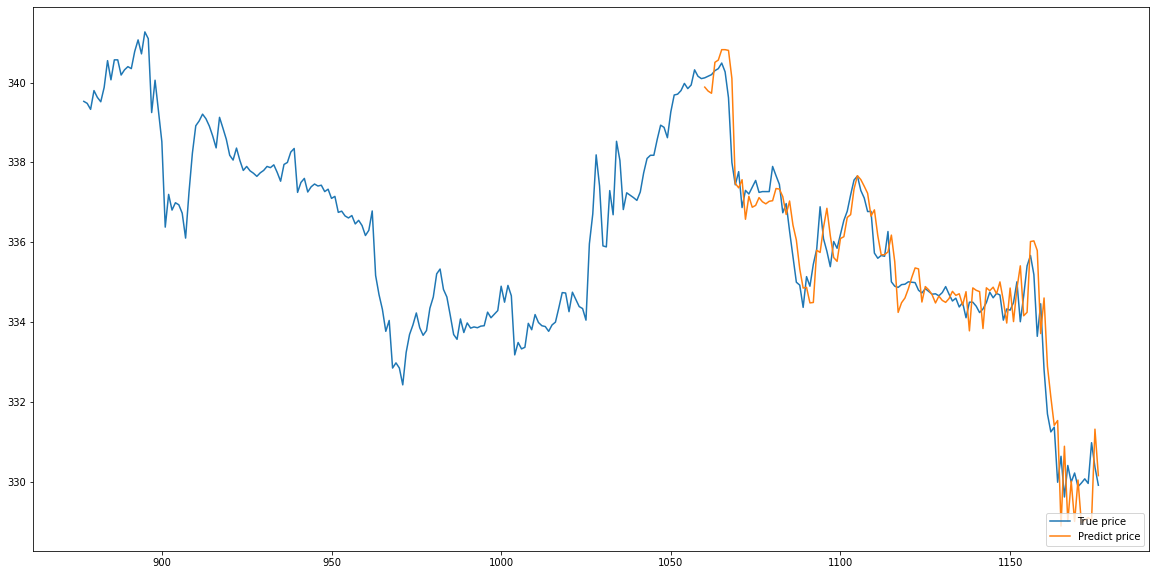

In [95]:
plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + SMA

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


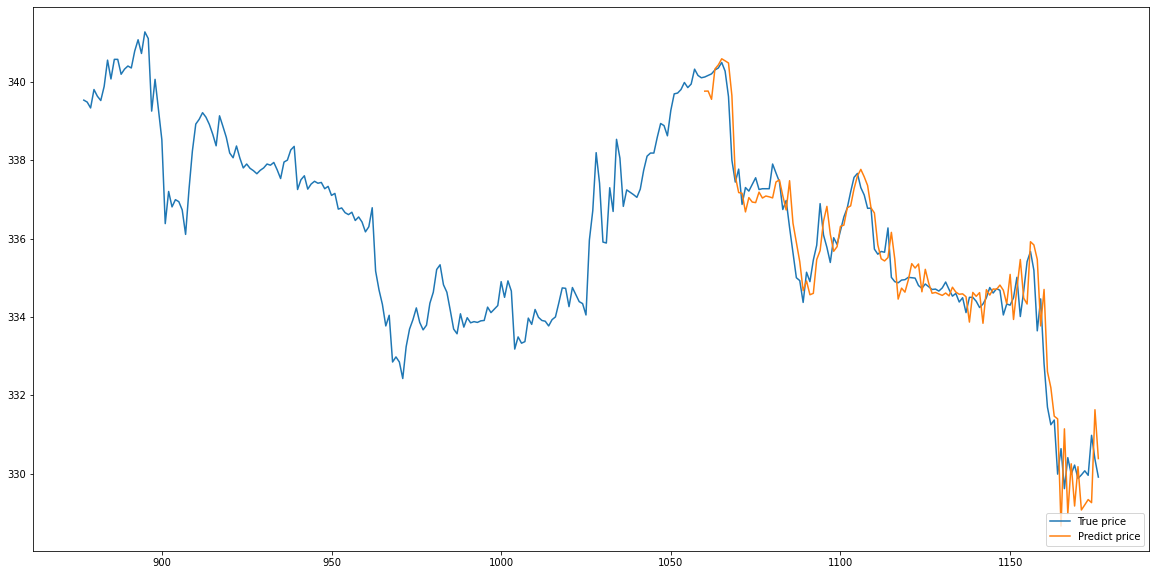

In [96]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'SMA']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["SMA_date_" + str(i)] = dataset.SMA.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'SMA'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_SMA.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_SMA.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + RSI

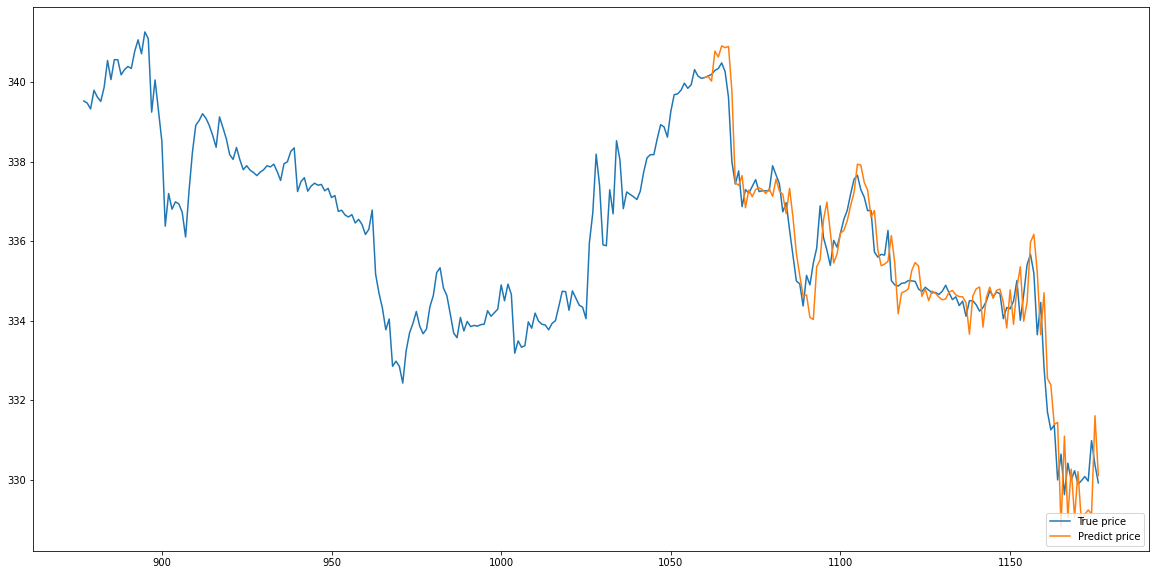

In [97]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'RSI']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["RSI_date_" + str(i)] = dataset.RSI.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'RSI'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_RSI.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_RSI.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS

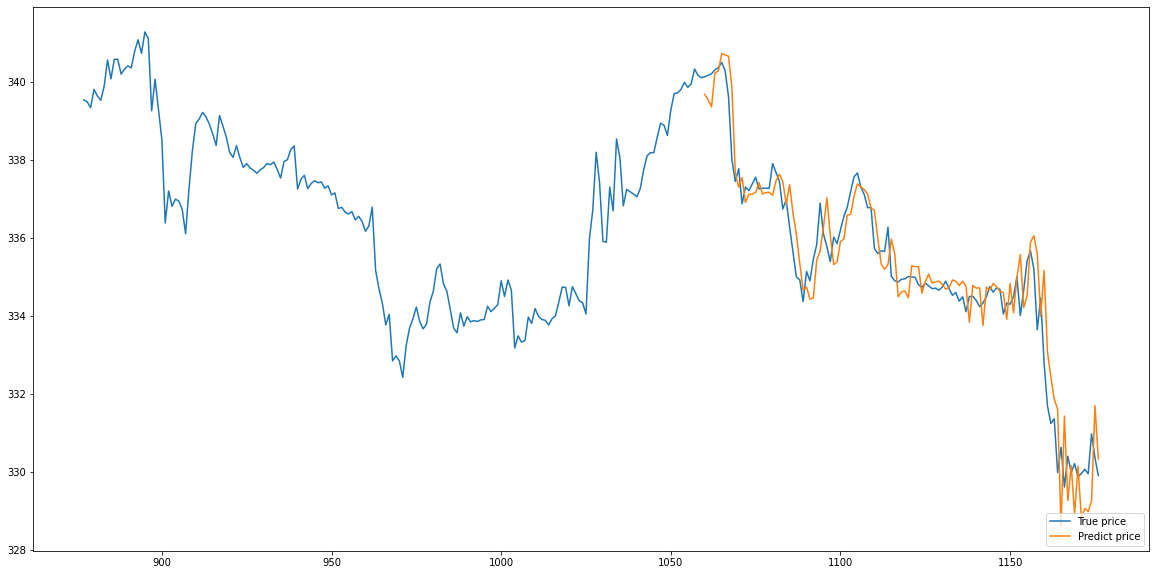

In [98]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["RLB_date_" + str(i)] = dataset['Real Lower Band'].shift(i)
    dataset["RMB_date_" + str(i)] = dataset['Real Middle Band'].shift(i)
    dataset["RUB_date_" + str(i)] = dataset['Real Upper Band'].shift(i)


dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_BBANDS.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_BBANDS.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + ROC

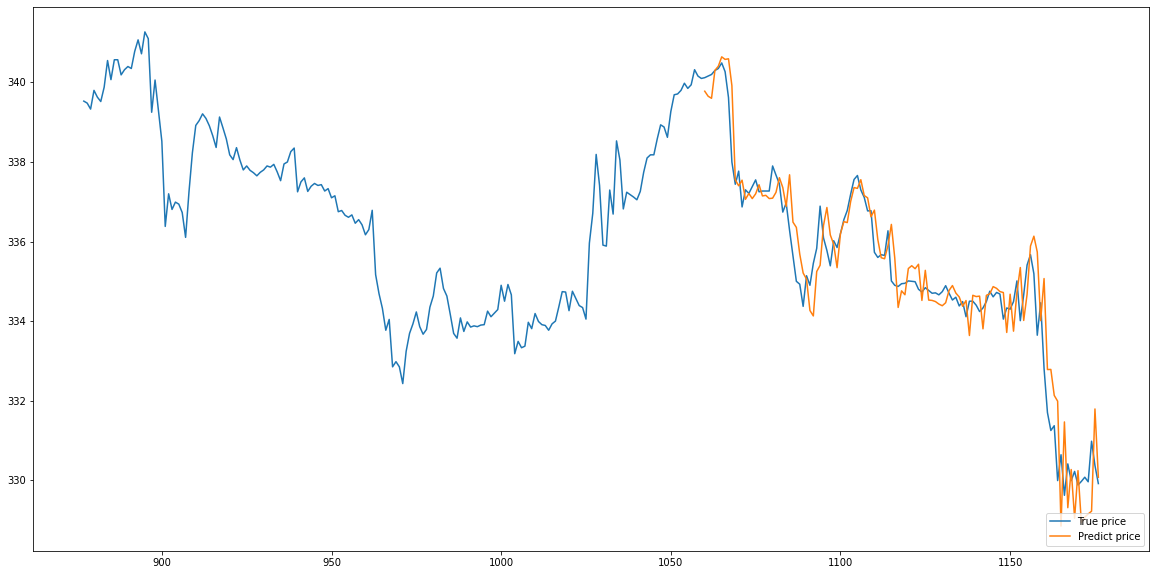

In [99]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["RLB_date_" + str(i)] = dataset['Real Lower Band'].shift(i)
    dataset["RMB_date_" + str(i)] = dataset['Real Middle Band'].shift(i)
    dataset["RUB_date_" + str(i)] = dataset['Real Upper Band'].shift(i)
    dataset["ROC_date_" + str(i)] = dataset.ROC.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_BBANDS_ROC.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_BBANDS_ROC.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + RSI

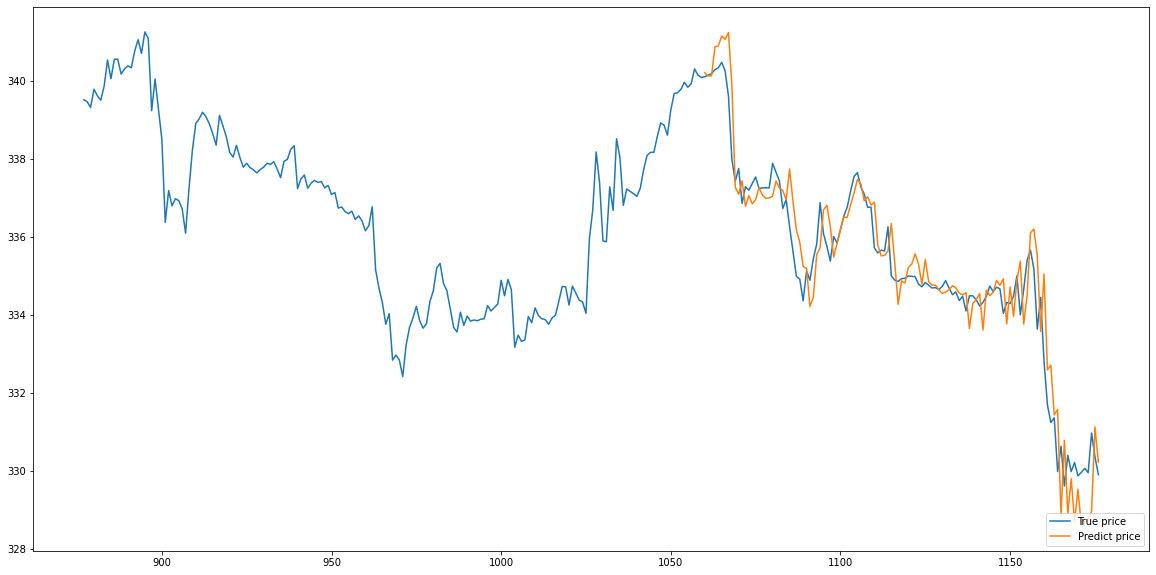

In [100]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'RSI']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["RLB_date_" + str(i)] = dataset['Real Lower Band'].shift(i)
    dataset["RMB_date_" + str(i)] = dataset['Real Middle Band'].shift(i)
    dataset["RUB_date_" + str(i)] = dataset['Real Upper Band'].shift(i)
    dataset["RSI_date_" + str(i)] = dataset.RSI.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'RSI'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_BBANDS_RSI.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_BBANDS_RSI.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + SMA

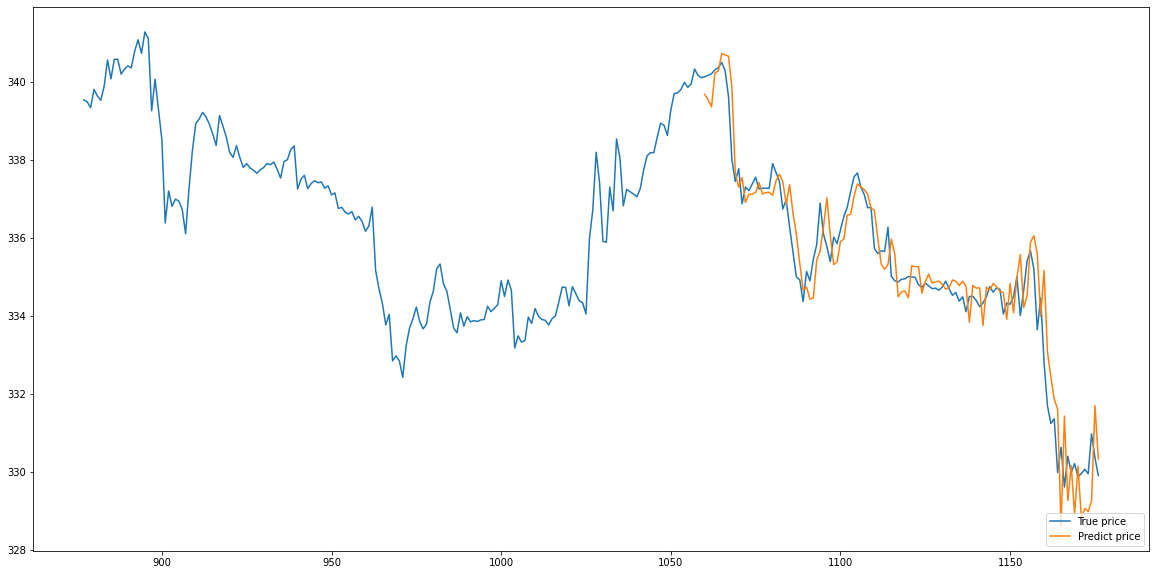

In [101]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'SMA']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["RLB_date_" + str(i)] = dataset['Real Lower Band'].shift(i)
    dataset["RMB_date_" + str(i)] = dataset['Real Middle Band'].shift(i)
    dataset["RUB_date_" + str(i)] = dataset['Real Upper Band'].shift(i)
    dataset["SMA_date_" + str(i)] = dataset.SMA.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'SMA'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_BBANDS_SMA.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_BBANDS_SMA.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + ROC + RSI

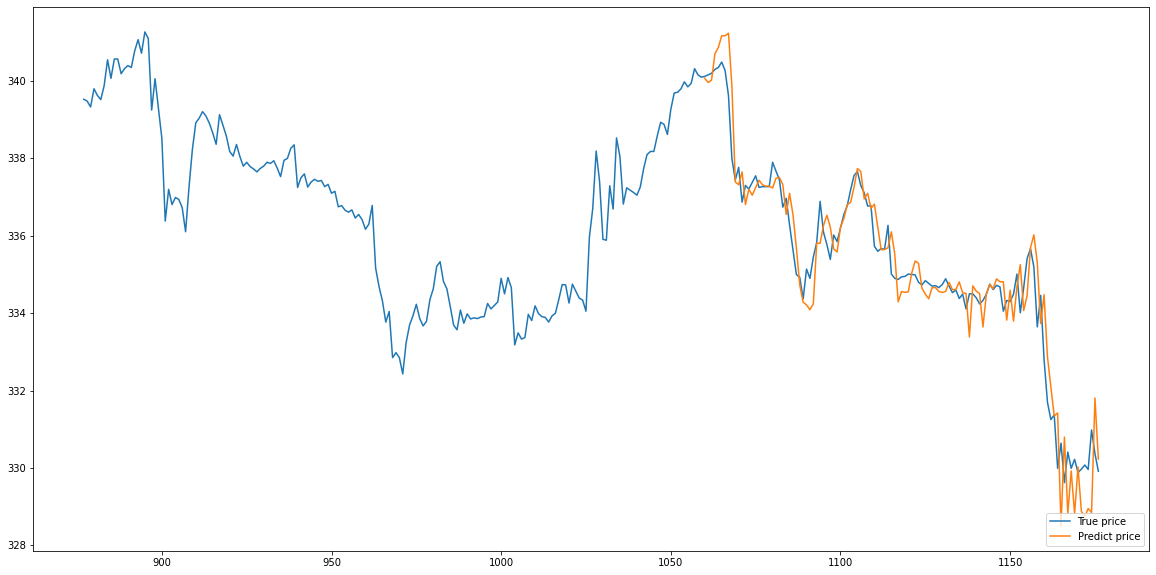

In [102]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'ROC', 'RSI']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["ROC_date_" + str(i)] = dataset.ROC.shift(i)
    dataset["RSI_date_" + str(i)] = dataset.RSI.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'ROC', 'RSI'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_ROC_RSI.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_ROC_RSI.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + ROC + SMA

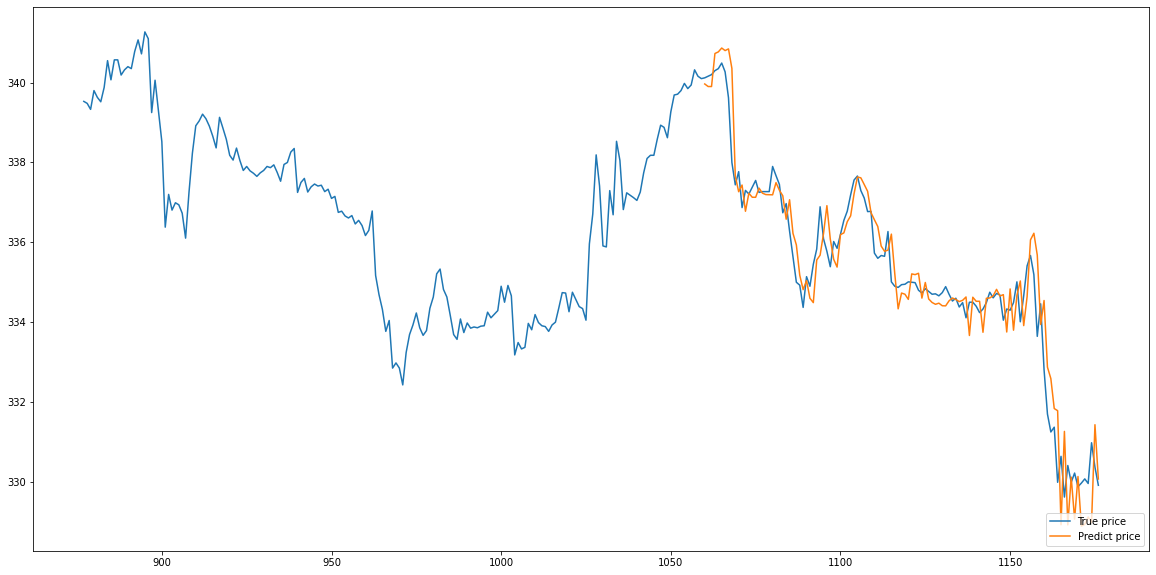

In [103]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'ROC', 'SMA']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["ROC_date_" + str(i)] = dataset.ROC.shift(i)
    dataset["SMA_date_" + str(i)] = dataset.SMA.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'ROC', 'SMA'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_ROC_SMA.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_ROC_SMA.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + RSI + SMA

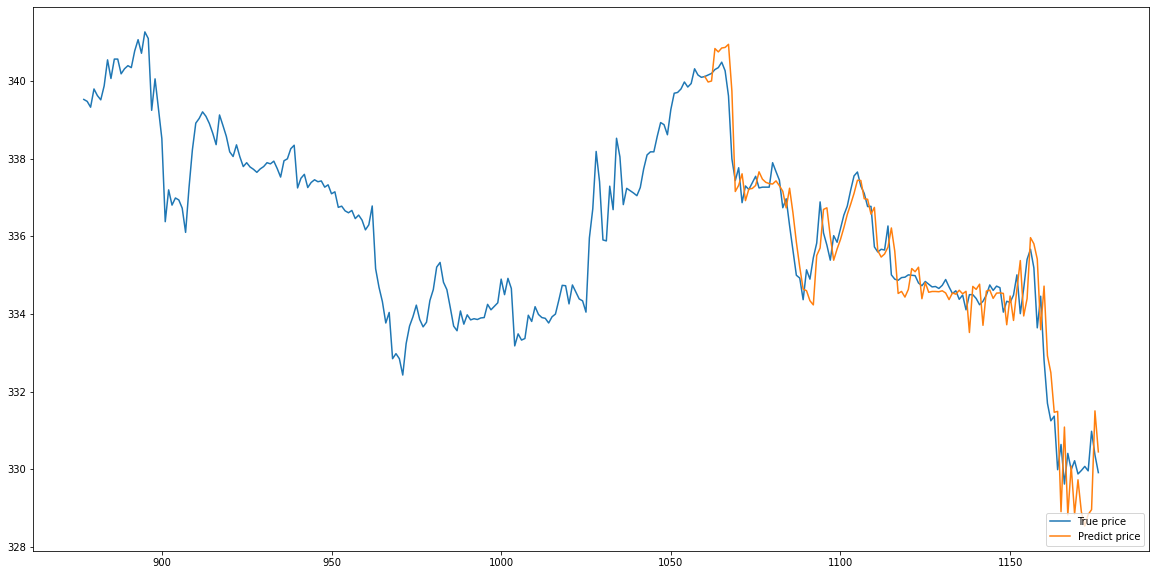

In [104]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'RSI', 'SMA']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["RSI_date_" + str(i)] = dataset.RSI.shift(i)
    dataset["SMA_date_" + str(i)] = dataset.SMA.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'RSI', 'SMA'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_RSI_SMA.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_RSI_SMA.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + ROC + RSI

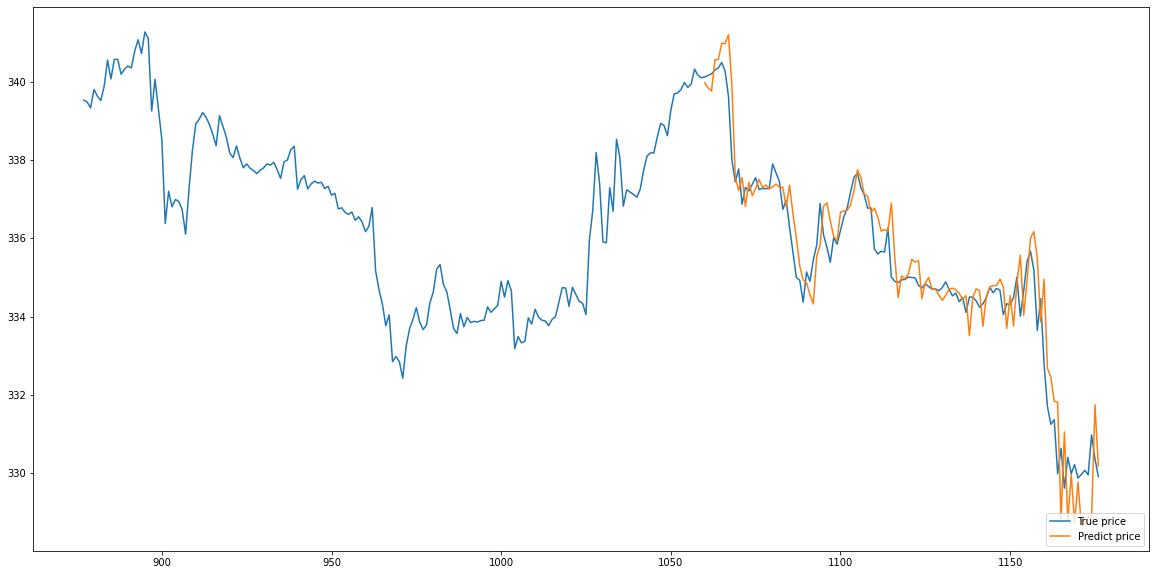

In [105]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'RSI']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["RLB_date_" + str(i)] = dataset['Real Lower Band'].shift(i)
    dataset["RMB_date_" + str(i)] = dataset['Real Middle Band'].shift(i)
    dataset["RUB_date_" + str(i)] = dataset['Real Upper Band'].shift(i)
    dataset["ROC_date_" + str(i)] = dataset.ROC.shift(i)
    dataset["RSI_date_" + str(i)] = dataset.RSI.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'RSI'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_BBANDS_ROC_RSI.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_BBANDS_ROC_RSI.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

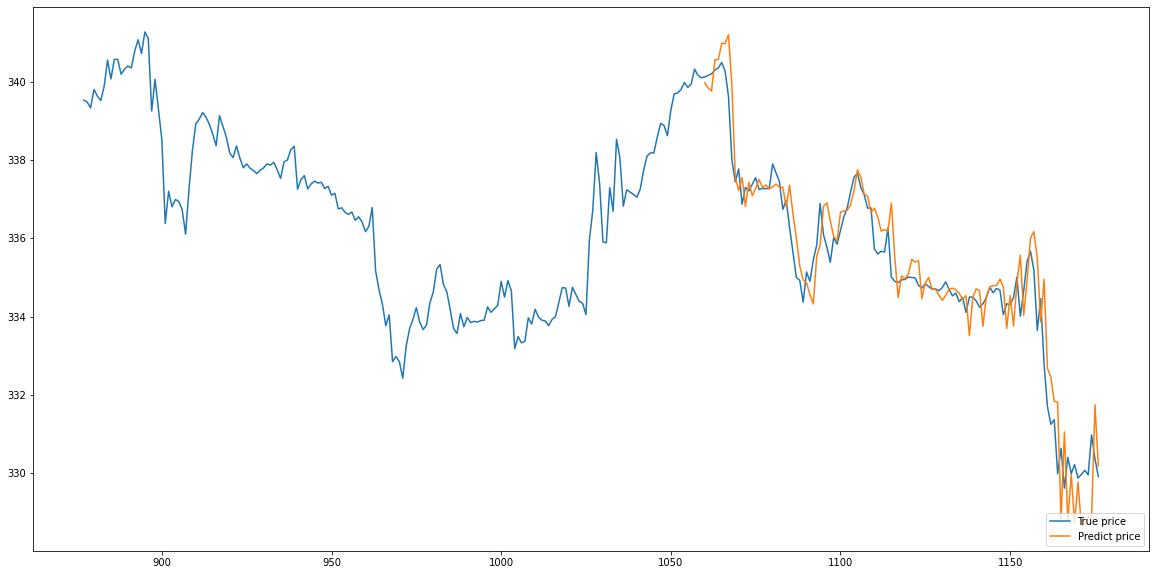

In [106]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'RSI']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["RLB_date_" + str(i)] = dataset['Real Lower Band'].shift(i)
    dataset["RMB_date_" + str(i)] = dataset['Real Middle Band'].shift(i)
    dataset["RUB_date_" + str(i)] = dataset['Real Upper Band'].shift(i)
    dataset["ROC_date_" + str(i)] = dataset.ROC.shift(i)
    dataset["RSI_date_" + str(i)] = dataset.RSI.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'RSI'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_BBANDS_ROC_RSI.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_BBANDS_ROC_RSI.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + ROC + SMA

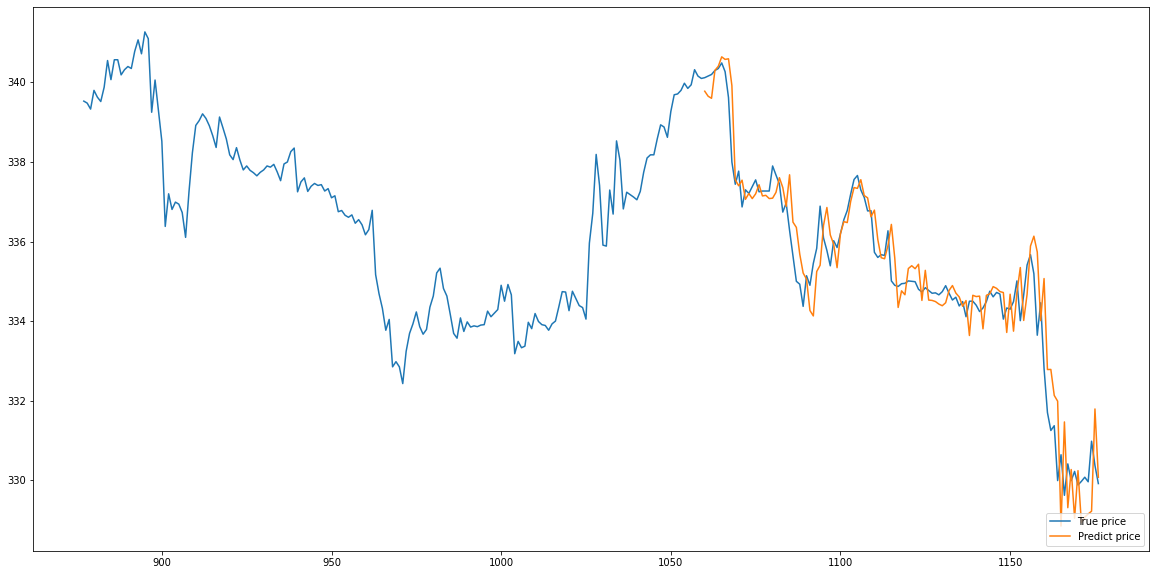

In [107]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'SMA']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["RLB_date_" + str(i)] = dataset['Real Lower Band'].shift(i)
    dataset["RMB_date_" + str(i)] = dataset['Real Middle Band'].shift(i)
    dataset["RUB_date_" + str(i)] = dataset['Real Upper Band'].shift(i)
    dataset["ROC_date_" + str(i)] = dataset.ROC.shift(i)
    dataset["SMA_date_" + str(i)] = dataset.SMA.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'SMA'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_BBANDS_ROC_SMA.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_BBANDS_ROC_SMA.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + RSI + SMA

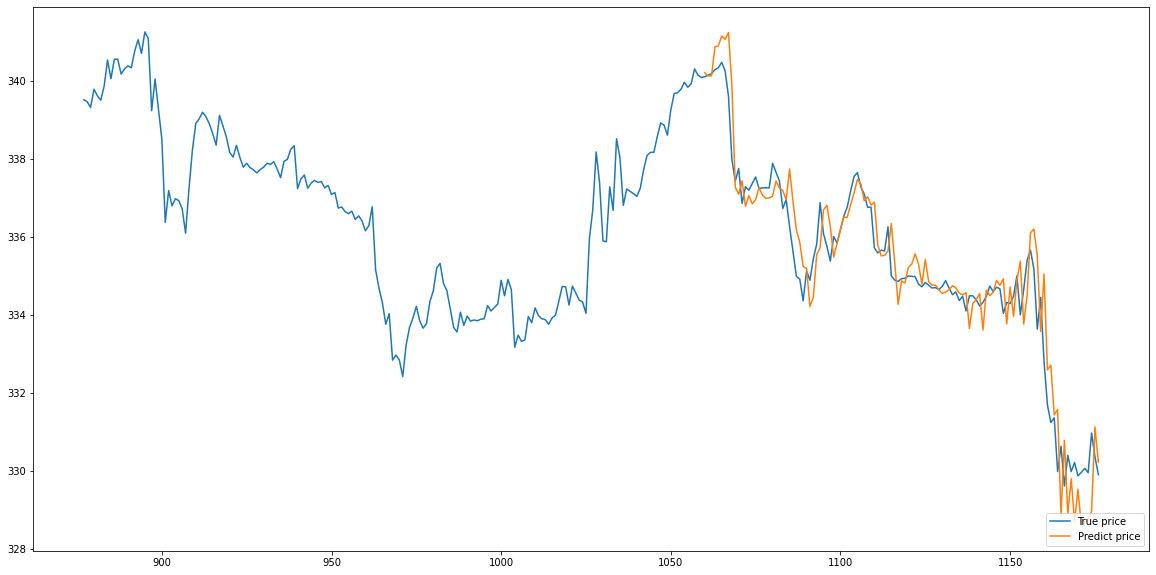

In [108]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'RSI', 'SMA']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["RLB_date_" + str(i)] = dataset['Real Lower Band'].shift(i)
    dataset["RMB_date_" + str(i)] = dataset['Real Middle Band'].shift(i)
    dataset["RUB_date_" + str(i)] = dataset['Real Upper Band'].shift(i)
    dataset["RSI_date_" + str(i)] = dataset.RSI.shift(i)
    dataset["RMA_date_" + str(i)] = dataset.SMA.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'RSI', 'SMA'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_BBANDS_RSI_SMA.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_BBANDS_RSI_SMA.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + ROC + RSI + SMA

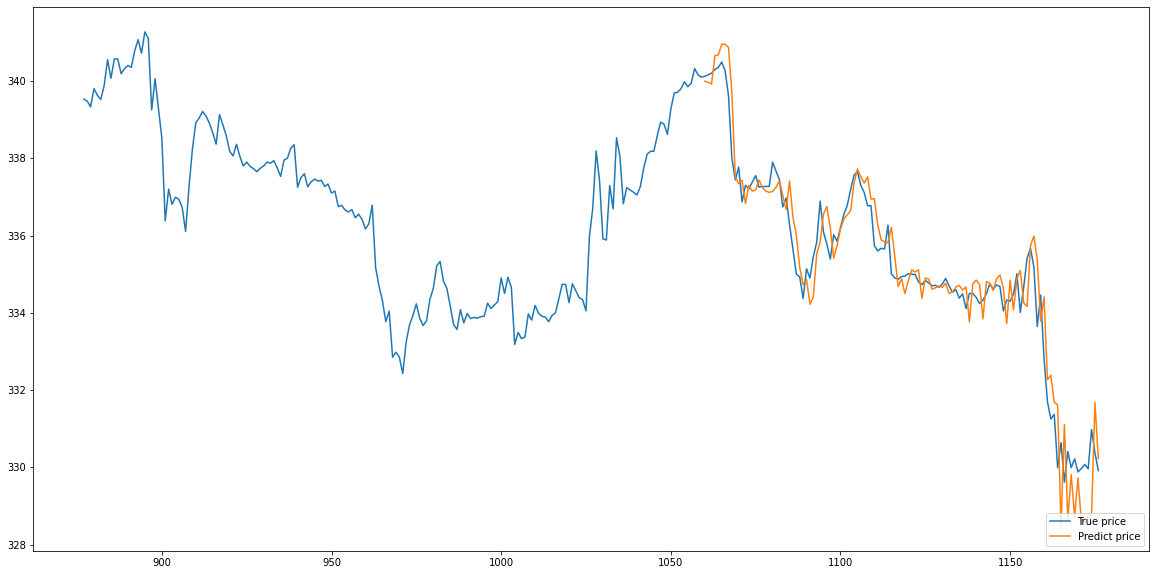

In [109]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'ROC', 'RSI', 'SMA']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["ROC_date_" + str(i)] = dataset.ROC.shift(i)
    dataset["RSI_date_" + str(i)] = dataset.RSI.shift(i)
    dataset["SMA_date_" + str(i)] = dataset.SMA.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'ROC', 'RSI', 'SMA'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_ROC_RSI_SMA.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_ROC_RSI_SMA.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + ROC + RSI + SMA

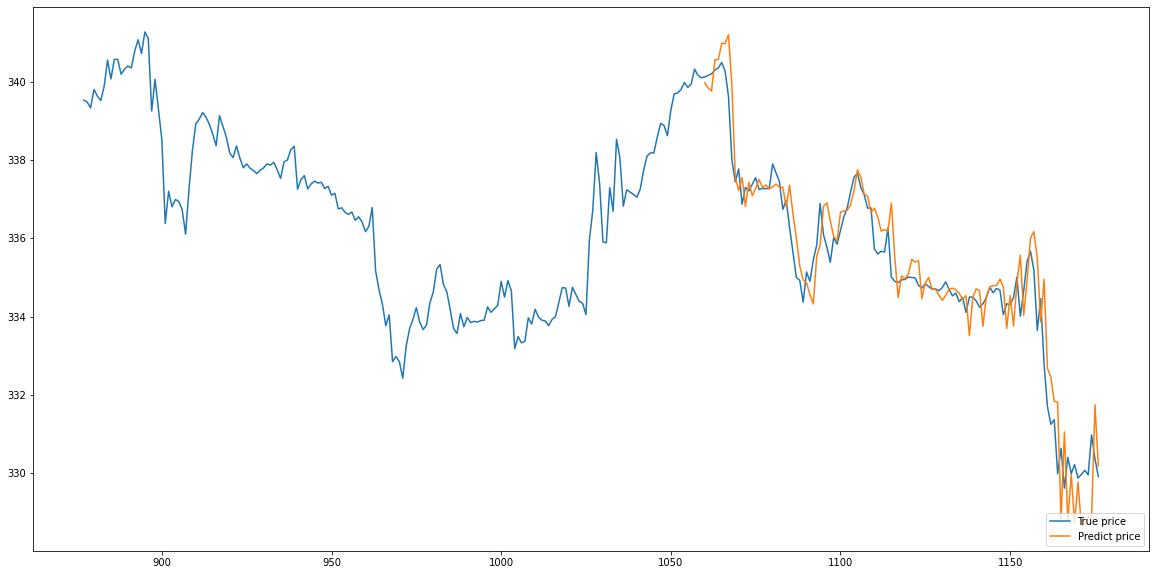

In [110]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'RSI', 'SMA']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["RLB_date_" + str(i)] = dataset['Real Lower Band'].shift(i)
    dataset["RMB_date_" + str(i)] = dataset['Real Middle Band'].shift(i)
    dataset["RUB_date_" + str(i)] = dataset['Real Upper Band'].shift(i)
    dataset["ROC_date_" + str(i)] = dataset.ROC.shift(i)
    dataset["RSI_date_" + str(i)] = dataset.RSI.shift(i)
    dataset["RMA_date_" + str(i)] = dataset.SMA.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'RSI', 'SMA'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_BBANDS_ROC_RSI_SMA.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_BBANDS_ROC_RSI_SMA.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

### Predict Future

In [111]:
def xgboost_predict_future(data, modelName, indicatorArr, period):
    modelFileName = './MODEL/' + modelName
    sorted(indicatorArr)
    for indicator in indicatorArr:
        if indicator == 'close':
            continue
        modelFileName = modelFileName + '_' + indicator
    modelFileName = modelFileName + '.dat'
    model = pickle.load(open(modelFileName, "rb"))
    numDataPoint = int(period / 15)
    
    temp = indicatorArr.copy()
    temp.append('volume')
    data = data[temp]
    data = data[-5:]
    
    X = pd.DataFrame({})
    for column in data.columns:
        n = len(data)
        for i in range(1, n + 1):
            X[column + '_date_' + str(i)] = [data.iloc[n - i][column]] 
    
    predictedValue = model.predict(X)
    
    return predictedValue